In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [121]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (classification_report,
                             f1_score, roc_auc_score,
                             roc_curve, accuracy_score,
                             confusion_matrix, fbeta_score,
                             ConfusionMatrixDisplay,
                             make_scorer
                           )
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from collections import Counter

In [122]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [123]:
%cd /content/drive/My Drive/Datasets_FC_2025

/content/drive/My Drive/Datasets_FC_2025


In [124]:
train_df = pd.read_csv('train_dataset.csv')

In [125]:
train_df.head()

,Customer_ID,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,...,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio,next_month_default
0,5017,2,0,2,60000,25.0,2,2,2,0,...,20750.63,2000.21,0.00,1134.85,1821.78,1500.03,1500.24,41511.50,0.03,0
1,5018,2,1,1,290000,24.0,0,0,-2,-2,...,1350.30,0.00,0.17,0.00,2700.10,0.00,1349.72,2534.50,0.27,0
2,5019,1,0,2,180000,63.0,0,0,0,0,...,52991.51,2086.94,2199.99,1845.66,2000.35,1923.00,1999.78,50422.00,0.04,0
3,5020,1,1,2,210000,43.0,0,0,0,0,...,76945.47,3348.07,3380.91,3400.45,2683.97,2744.00,2892.10,86229.50,0.04,0
4,5021,2,0,1,280000,32.0,-2,-2,-2,-2,...,1.35,999.78,3186.27,45027.78,2100.09,0.01,0.27,11814.33,0.72,0


In [126]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25247 entries, 0 to 25246
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer_ID         25247 non-null  int64  
 1   marriage            25247 non-null  int64  
 2   sex                 25247 non-null  int64  
 3   education           25247 non-null  int64  
 4   LIMIT_BAL           25247 non-null  int64  
 5   age                 25121 non-null  float64
 6   pay_0               25247 non-null  int64  
 7   pay_2               25247 non-null  int64  
 8   pay_3               25247 non-null  int64  
 9   pay_4               25247 non-null  int64  
 10  pay_5               25247 non-null  int64  
 11  pay_6               25247 non-null  int64  
 12  Bill_amt1           25247 non-null  float64
 13  Bill_amt2           25247 non-null  float64
 14  Bill_amt3           25247 non-null  float64
 15  Bill_amt4           25247 non-null  float64
 16  Bill

In [127]:
train_df.isnull().sum()

,0
Customer_ID,0
marriage,0
sex,0
education,0
LIMIT_BAL,0
age,126
pay_0,0
pay_2,0
pay_3,0
pay_4,0


# Exploratory Data Analysis (EDA)

## Univariate Analysis

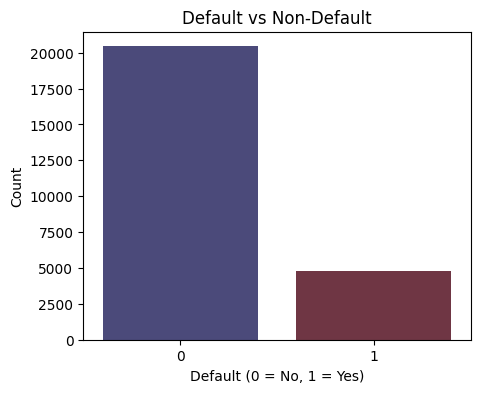

In [128]:
plt.figure(figsize=(5, 4))
sns.countplot(data=train_df, x='next_month_default', palette='icefire')
plt.title("Default vs Non-Default")
plt.xlabel("Default (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

In [129]:
feature_list = ["LIMIT_BAL", "age", "pay_0", "pay_2","pay_3","pay_4","pay_5","pay_6",
            "Bill_amt1", "Bill_amt2", "Bill_amt3", "Bill_amt4", "Bill_amt5", "Bill_amt6",
            "pay_amt1", "pay_amt2", "pay_amt3", "pay_amt4", "pay_amt5", "pay_amt6",
            "AVG_Bill_amt","PAY_TO_BILL_ratio"]

columns = 3

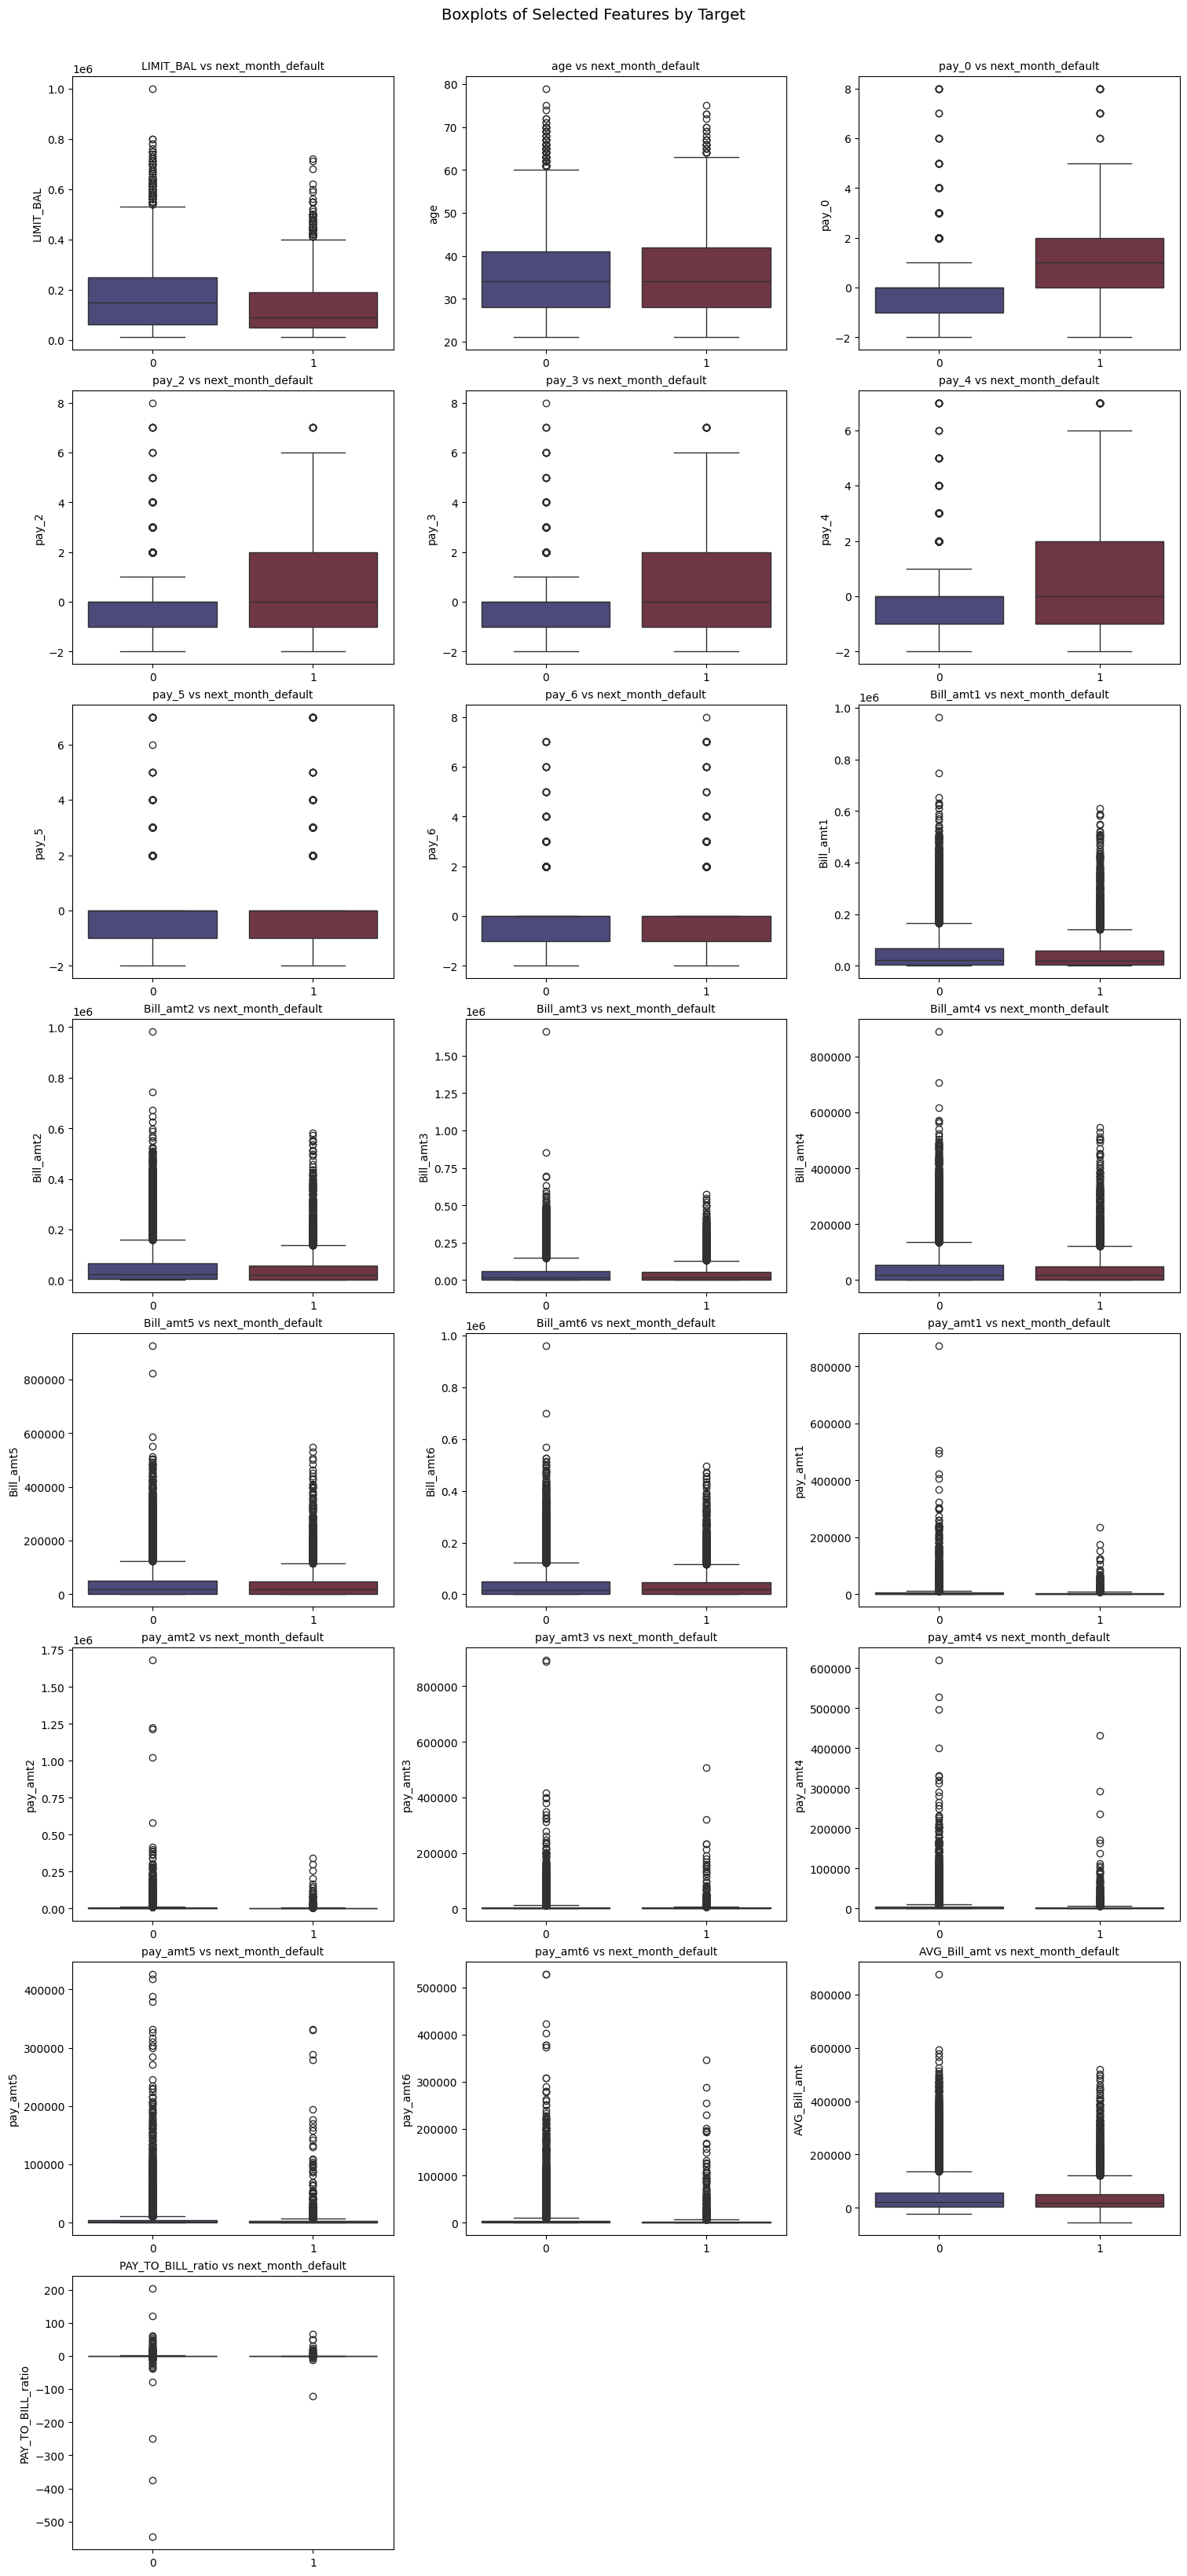

In [130]:
total = len(feature_list)
rows = (total + columns - 1) // columns
fig, axes = plt.subplots(rows, columns, figsize=(5 * columns, 4 * rows), constrained_layout=True)
axes = axes.flatten()
for idx, feature in enumerate(feature_list):
    ax = axes[idx]
    sns.boxplot(
        data=train_df,
        x='next_month_default',
        y=feature,
        palette='icefire',
        ax=ax
    )
    ax.set_title(f"{feature} vs {'next_month_default'}", fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel(feature)

for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle("Boxplots of Selected Features by Target", fontsize=14, y=1.02)
plt.show()

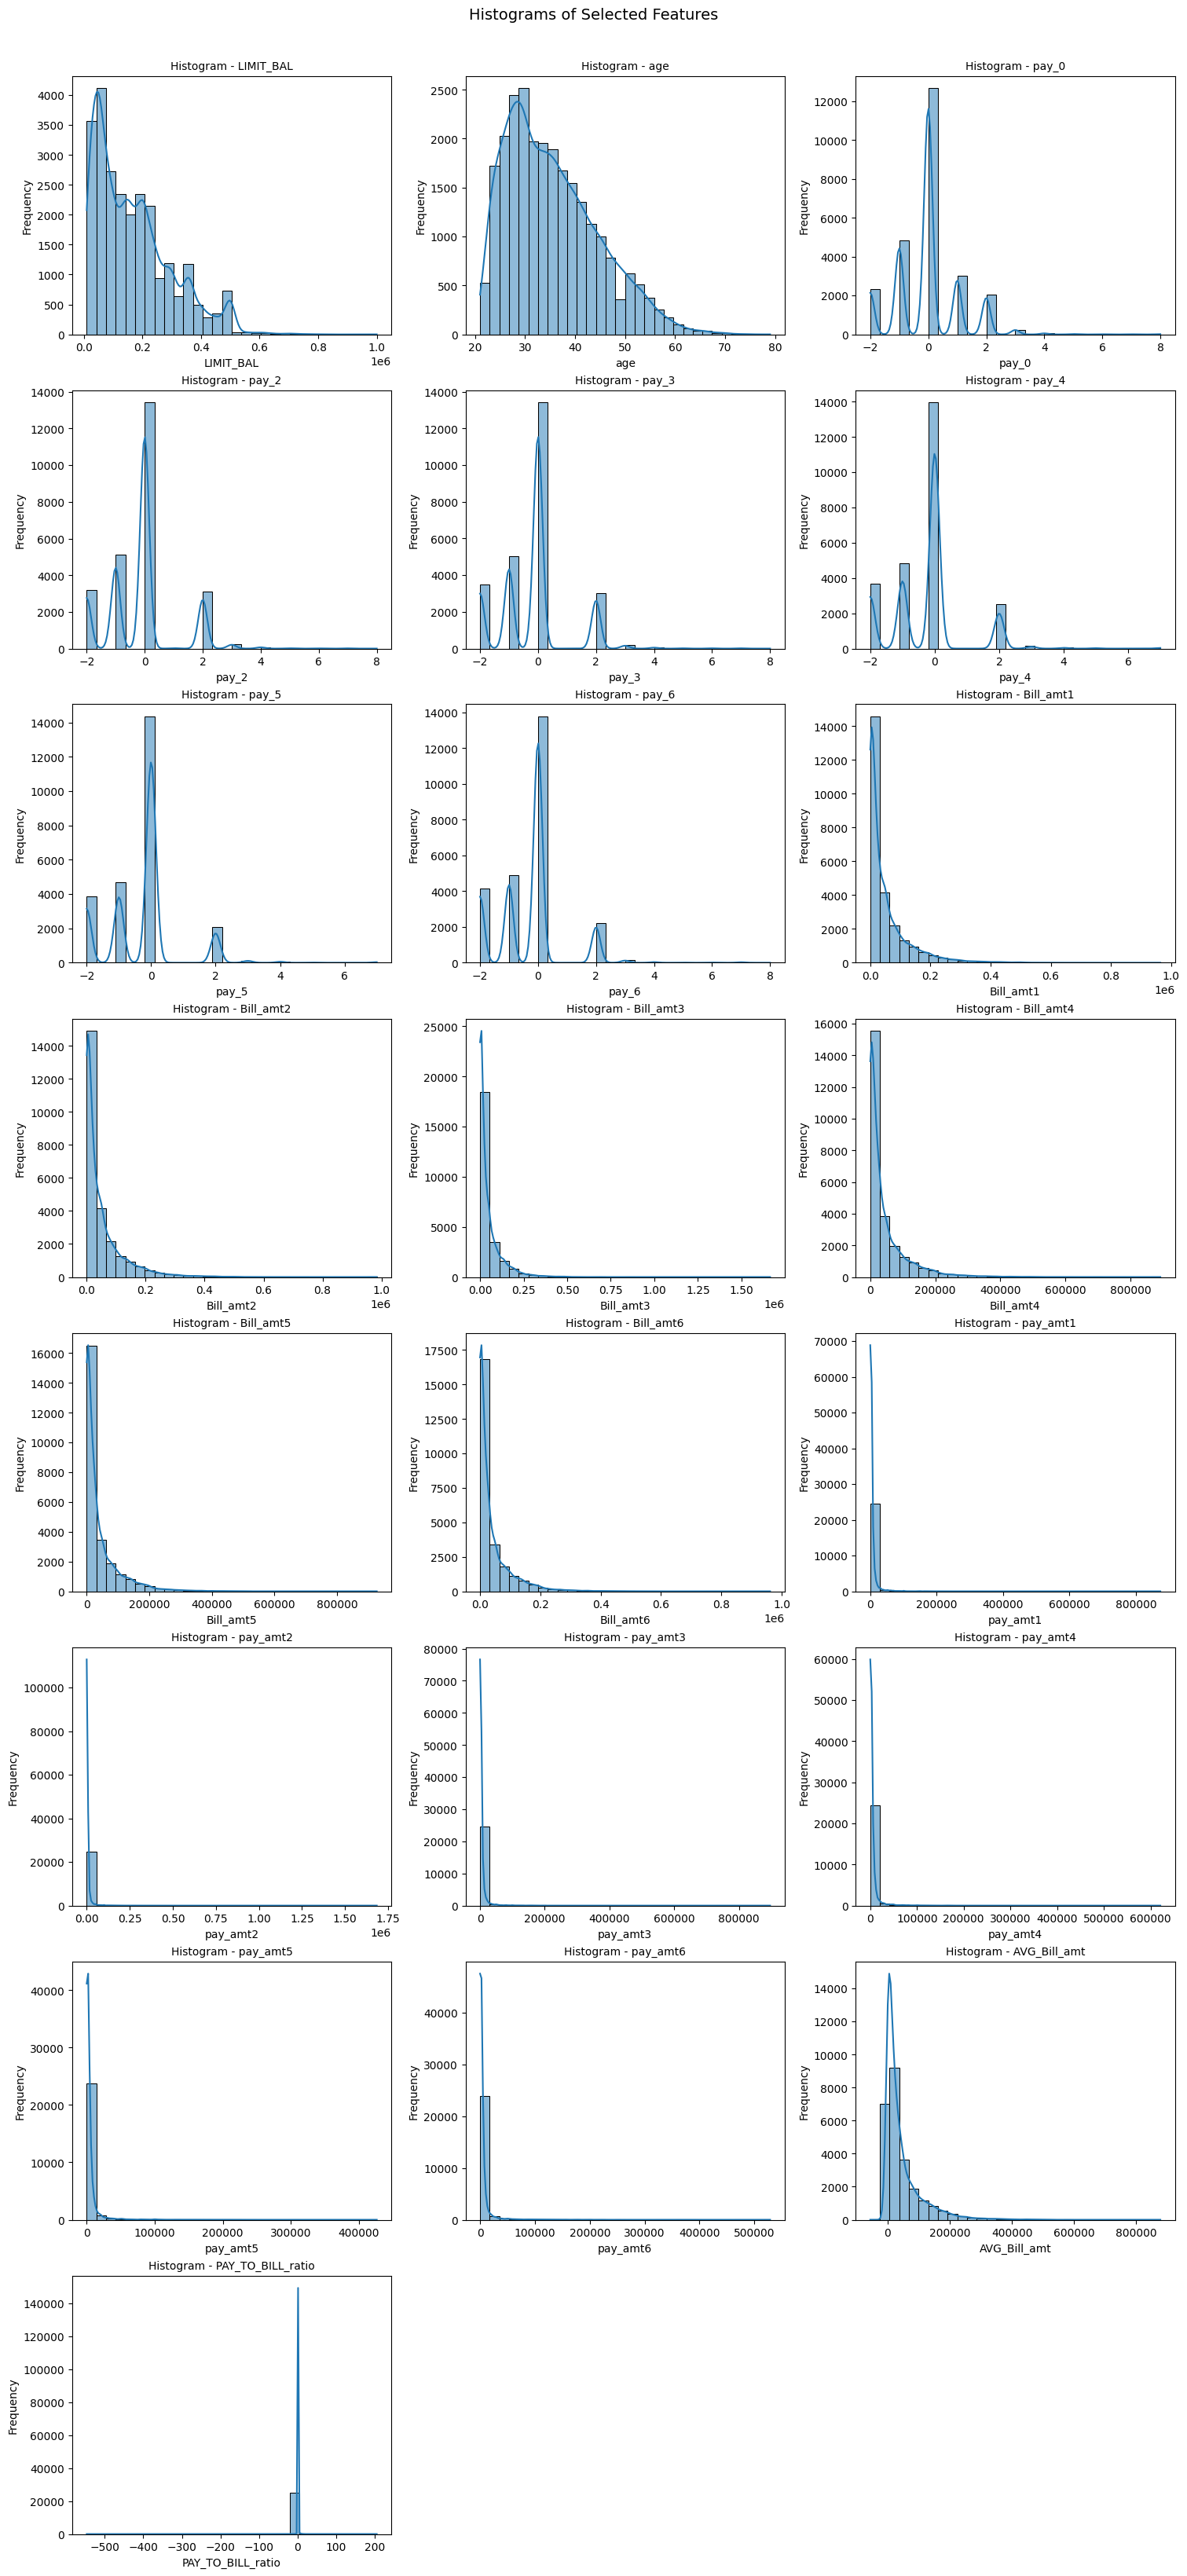

In [131]:
total = len(feature_list)
rows = (total + columns - 1) // columns
fig, axes = plt.subplots(rows, columns, figsize=(5 * columns, 4 * rows), constrained_layout=True)
axes = axes.flatten()

for idx, feature in enumerate(feature_list):
    ax = axes[idx]
    sns.histplot(
        train_df[feature],
        bins=30,
        kde=True,
        palette='colorblind',
        ax=ax
    )
    ax.set_title(f"Histogram - {feature}", fontsize=10)
    ax.set_xlabel(feature)
    ax.set_ylabel("Frequency")

for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle("Histograms of Selected Features", fontsize=14, y=1.02)
plt.show()

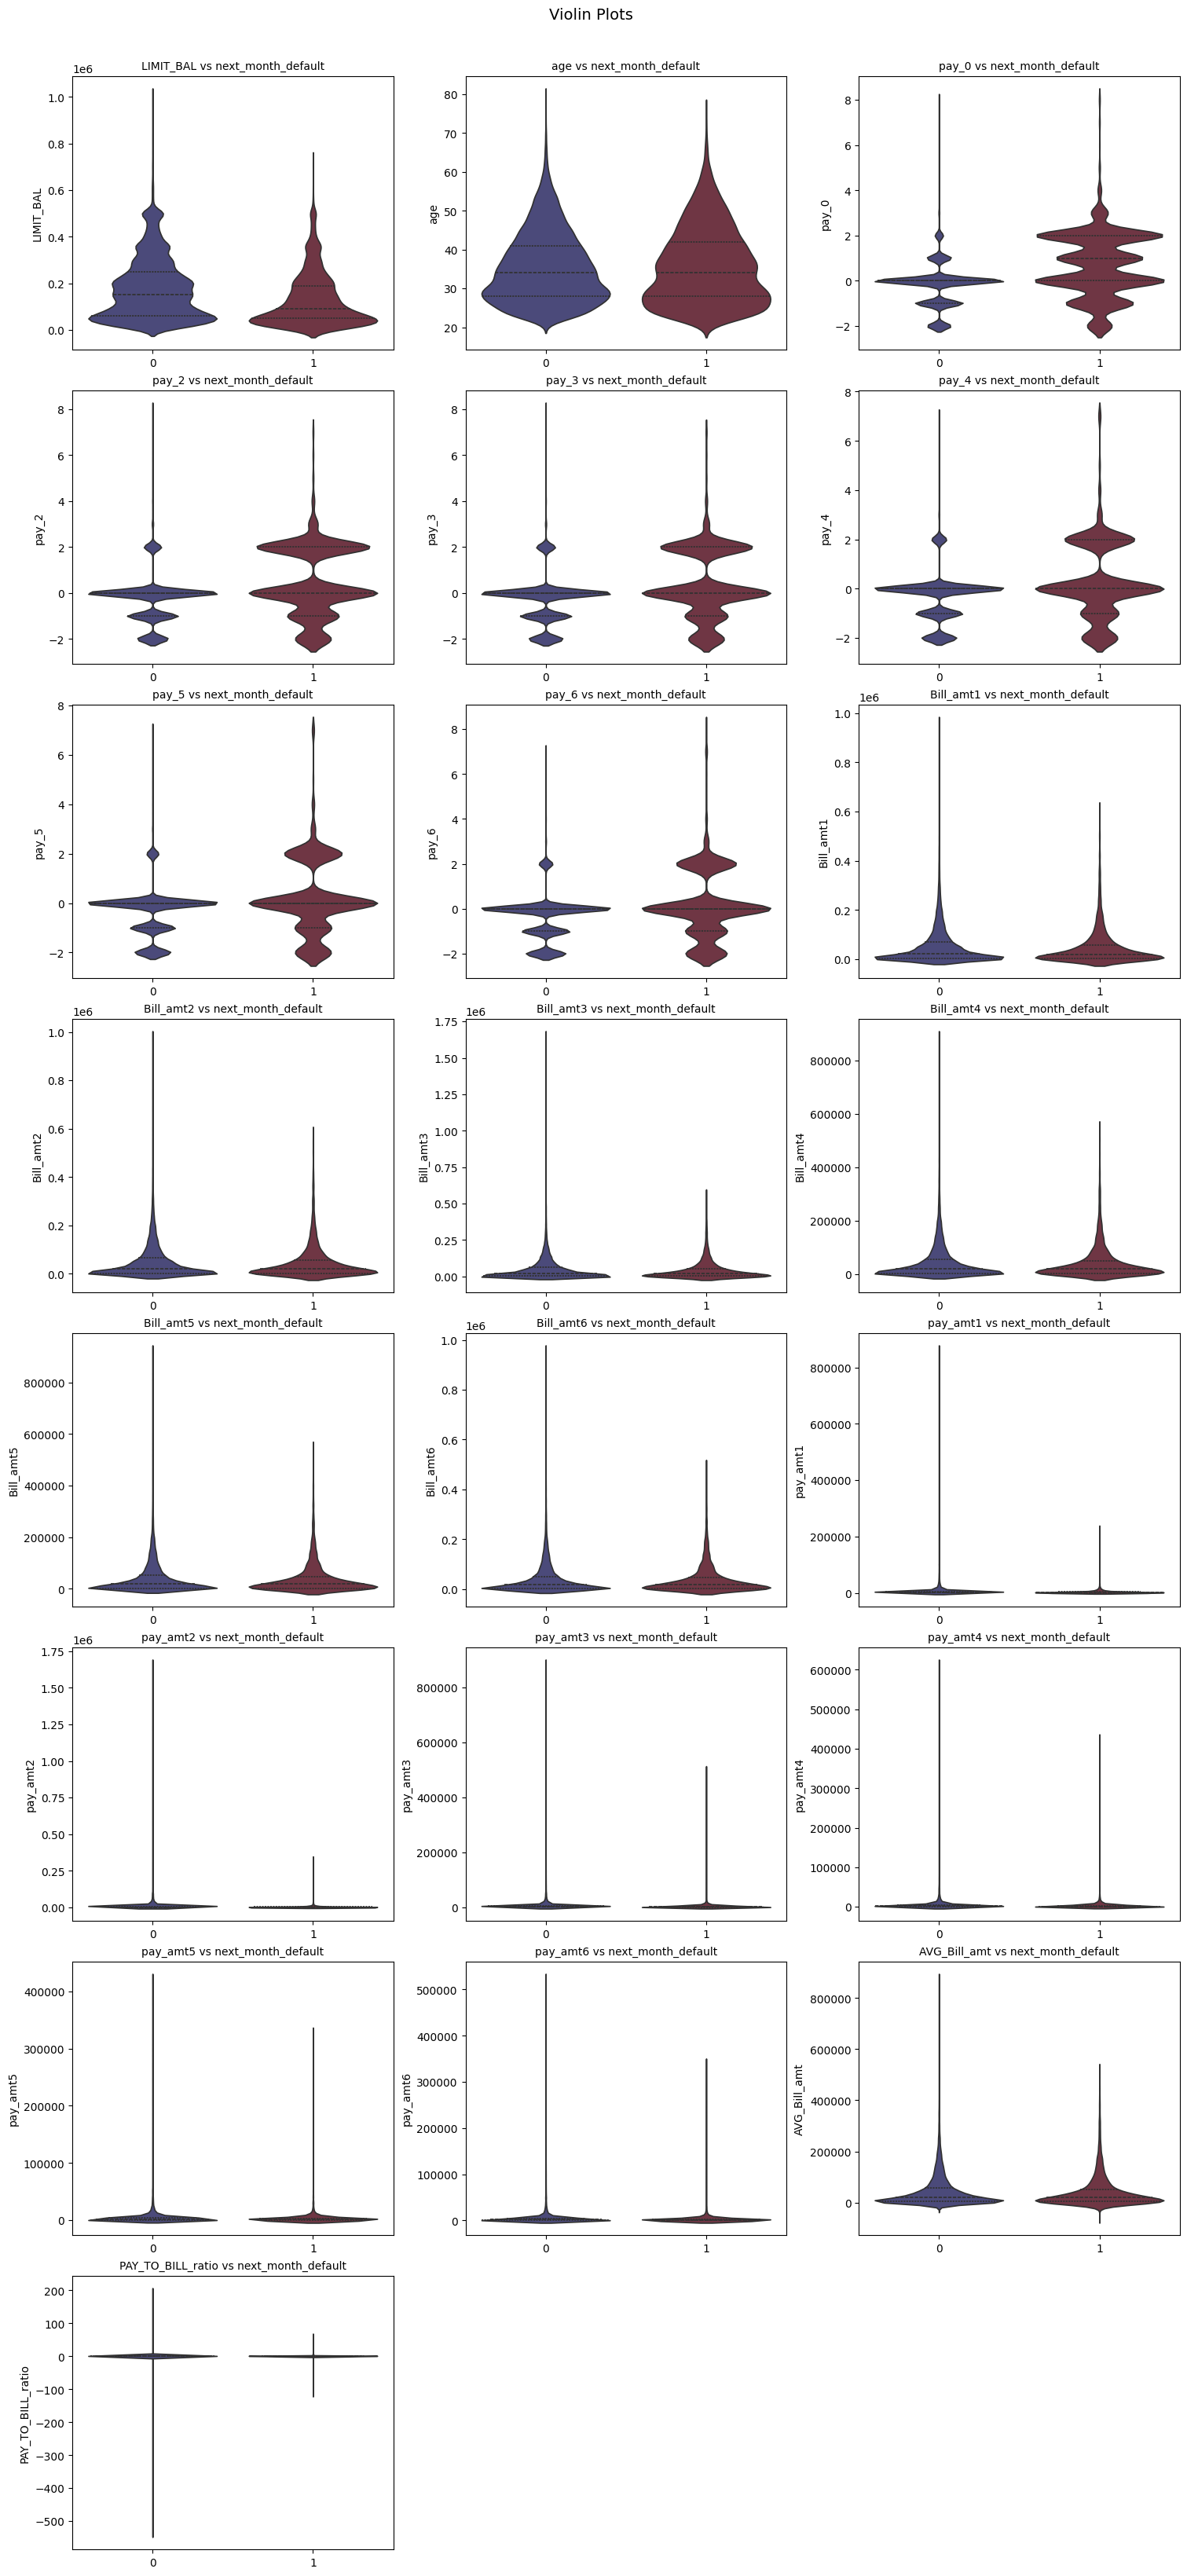

In [132]:
total = len(feature_list)
rows = (total + columns - 1) // columns
fig, axes = plt.subplots(rows, columns, figsize=(5 * columns, 4 * rows), constrained_layout=True)
axes = axes.flatten()
for idx, feature in enumerate(feature_list):
    ax = axes[idx]
    sns.violinplot(
        data=train_df,
        x='next_month_default',
        y=feature,
        palette='icefire',
        inner="quartile",
        ax=ax
    )
    ax.set_title(f"{feature} vs {'next_month_default'}", fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel(feature)
    ax.set_facecolor("white")

for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle("Violin Plots ", fontsize=14, y=1.02)
plt.show()

## Bivariate Analysis

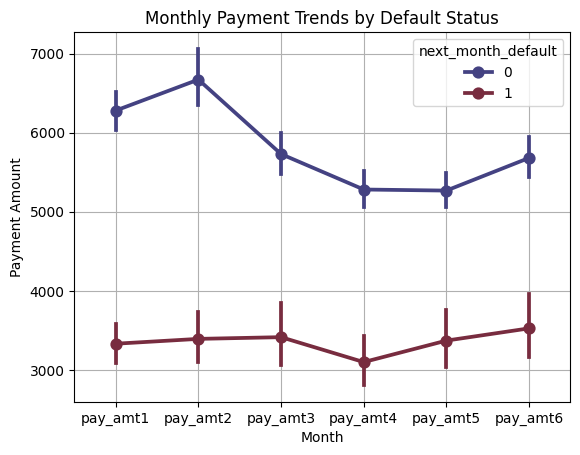

In [133]:
monthly_pay = [f'pay_amt{i}' for i in range(1, 7)]
df_melted = train_df.melt(id_vars='next_month_default', value_vars=monthly_pay, var_name='Month', value_name='Payment')

sns.pointplot(data=df_melted, x='Month', y='Payment', hue='next_month_default', palette='icefire')
plt.title("Monthly Payment Trends by Default Status")
plt.ylabel("Payment Amount")
plt.grid(True)
plt.show()

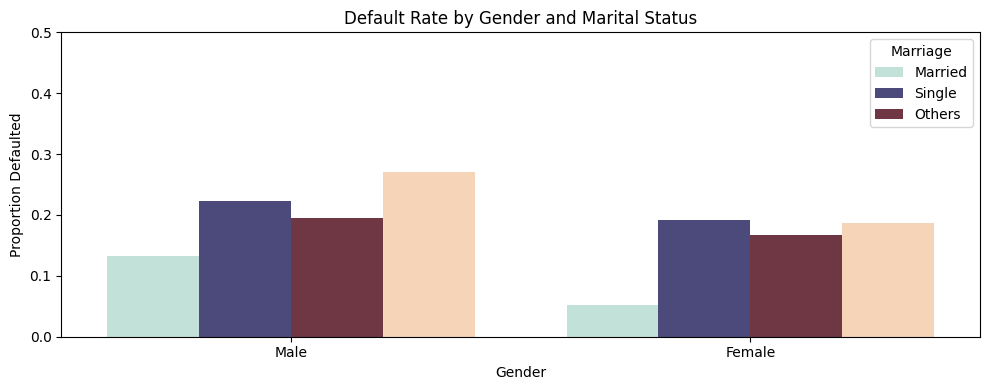

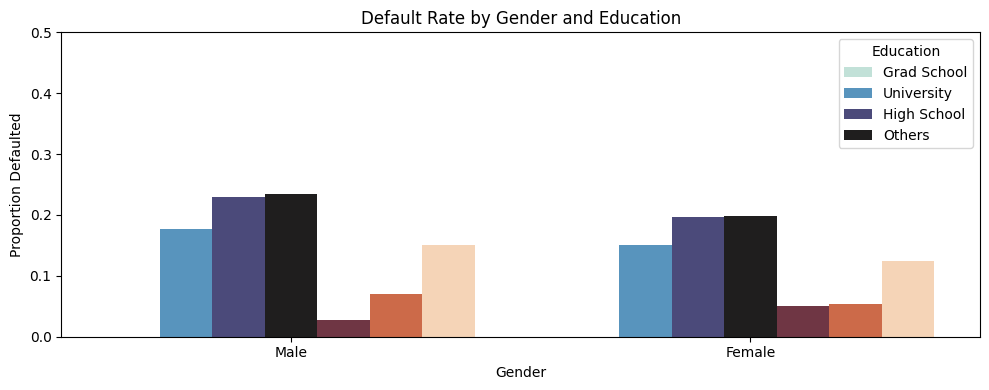

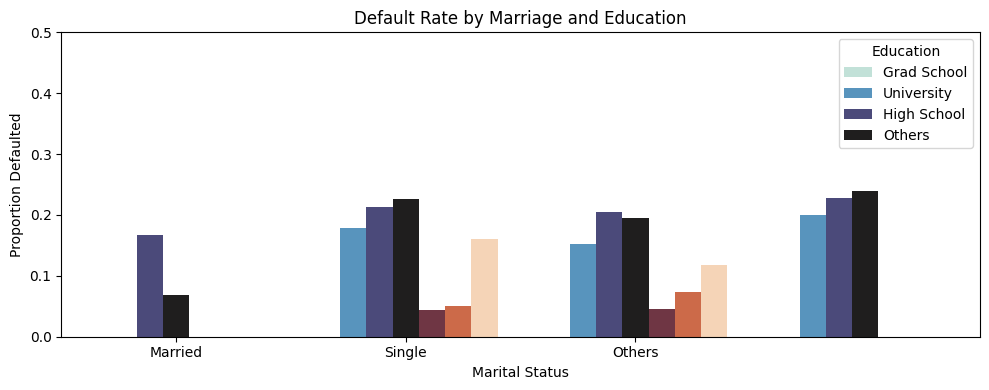

In [134]:
# Bar: Sex vs Default by Marriage
plt.figure(figsize=(10, 4))
sns.barplot(
    data=train_df,
    x="sex", y="next_month_default", hue="marriage",
    palette="icefire", errorbar=None
)
plt.title("Default Rate by Gender and Marital Status")
plt.xlabel("Gender")
plt.ylabel("Proportion Defaulted")
plt.ylim(0, 0.5)
plt.xticks(ticks=[0, 1], labels=["Male", "Female"])
plt.legend(title="Marriage", labels=["Married", "Single", "Others"])
plt.tight_layout()
plt.show()

# Bar: Sex vs Default by Education
plt.figure(figsize=(10, 4))
sns.barplot(
    data=train_df,
    x="sex", y="next_month_default", hue="education",
    palette="icefire", errorbar=None
)
plt.title("Default Rate by Gender and Education")
plt.xlabel("Gender")
plt.ylabel("Proportion Defaulted")
plt.ylim(0, 0.5)
plt.xticks(ticks=[0, 1], labels=["Male", "Female"])
plt.legend(title="Education", labels=["Grad School", "University", "High School", "Others"])
plt.tight_layout()
plt.show()

# Bar: Marriage vs Default by Education
plt.figure(figsize=(10, 4))
sns.barplot(
    data=train_df,
    x="marriage", y="next_month_default", hue="education",
    palette="icefire", errorbar=None
)
plt.title("Default Rate by Marriage and Education")
plt.xlabel("Marital Status")
plt.ylabel("Proportion Defaulted")
plt.ylim(0, 0.5)
plt.xticks(ticks=[0, 1, 2], labels=["Married", "Single", "Others"])
plt.legend(title="Education", labels=["Grad School", "University", "High School", "Others"])
plt.tight_layout()
plt.show()


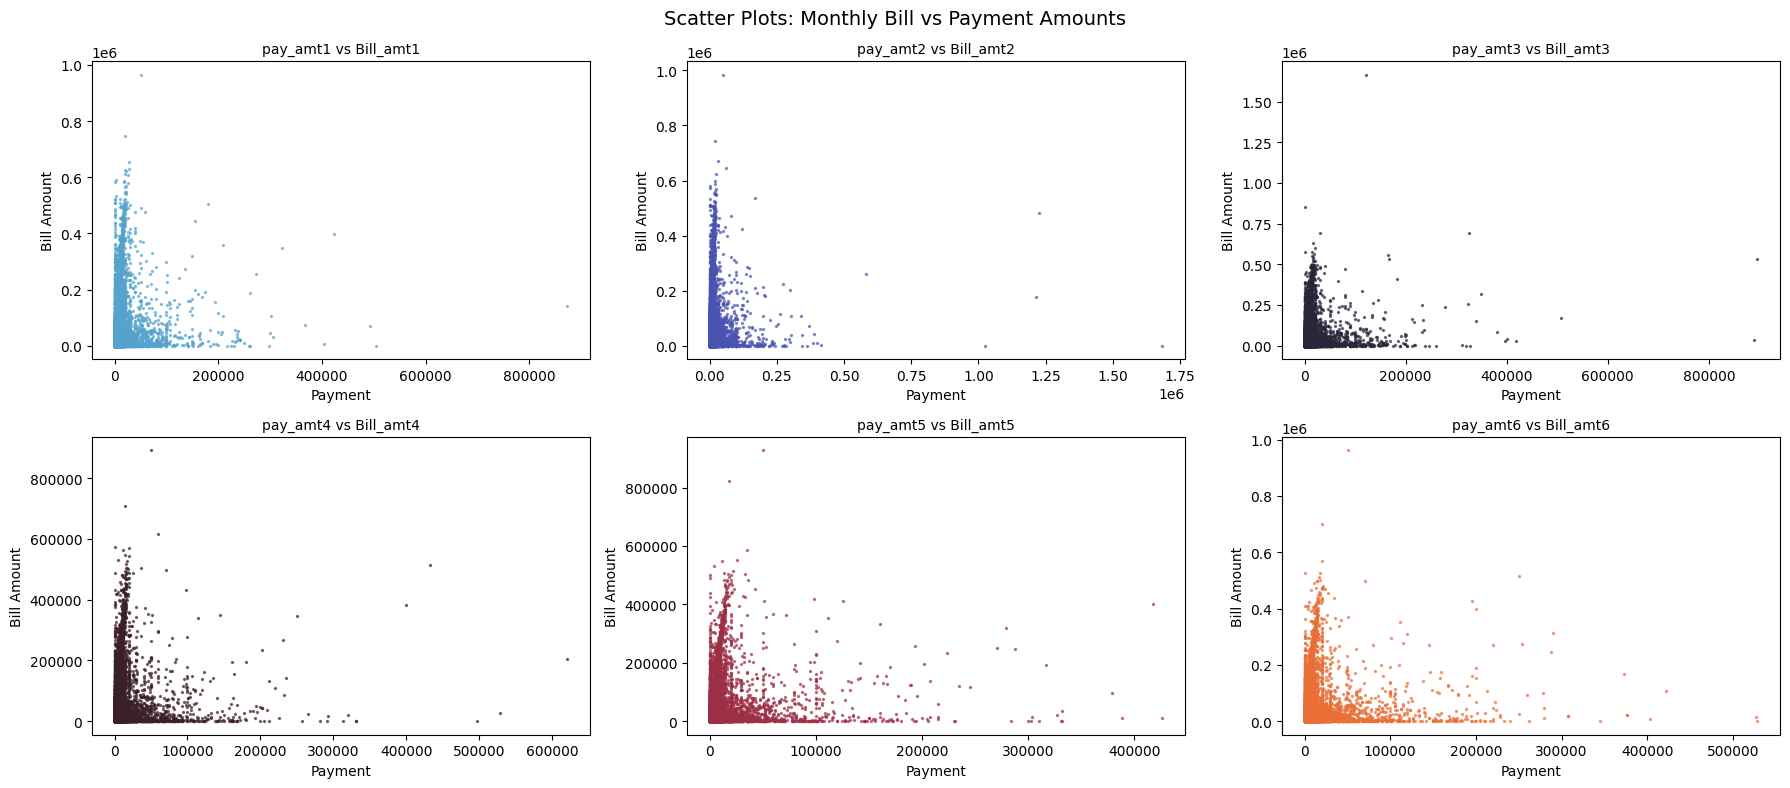

In [135]:
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
colors = sns.color_palette("icefire", 6)

for i in range(6):
    row = i // 3
    col = i % 3
    bill = f"Bill_amt{i+1}"
    pay = f"pay_amt{i+1}"

    axes[row, col].scatter(train_df[pay], train_df[bill], color=colors[i], s=2, alpha=0.6)
    axes[row, col].set_title(f"{pay} vs {bill}", fontsize=10)
    axes[row, col].set_xlabel("Payment")
    axes[row, col].set_ylabel("Bill Amount")
    axes[row, col].grid(False)

plt.suptitle("Scatter Plots: Monthly Bill vs Payment Amounts", fontsize=14)
plt.tight_layout()
plt.show()

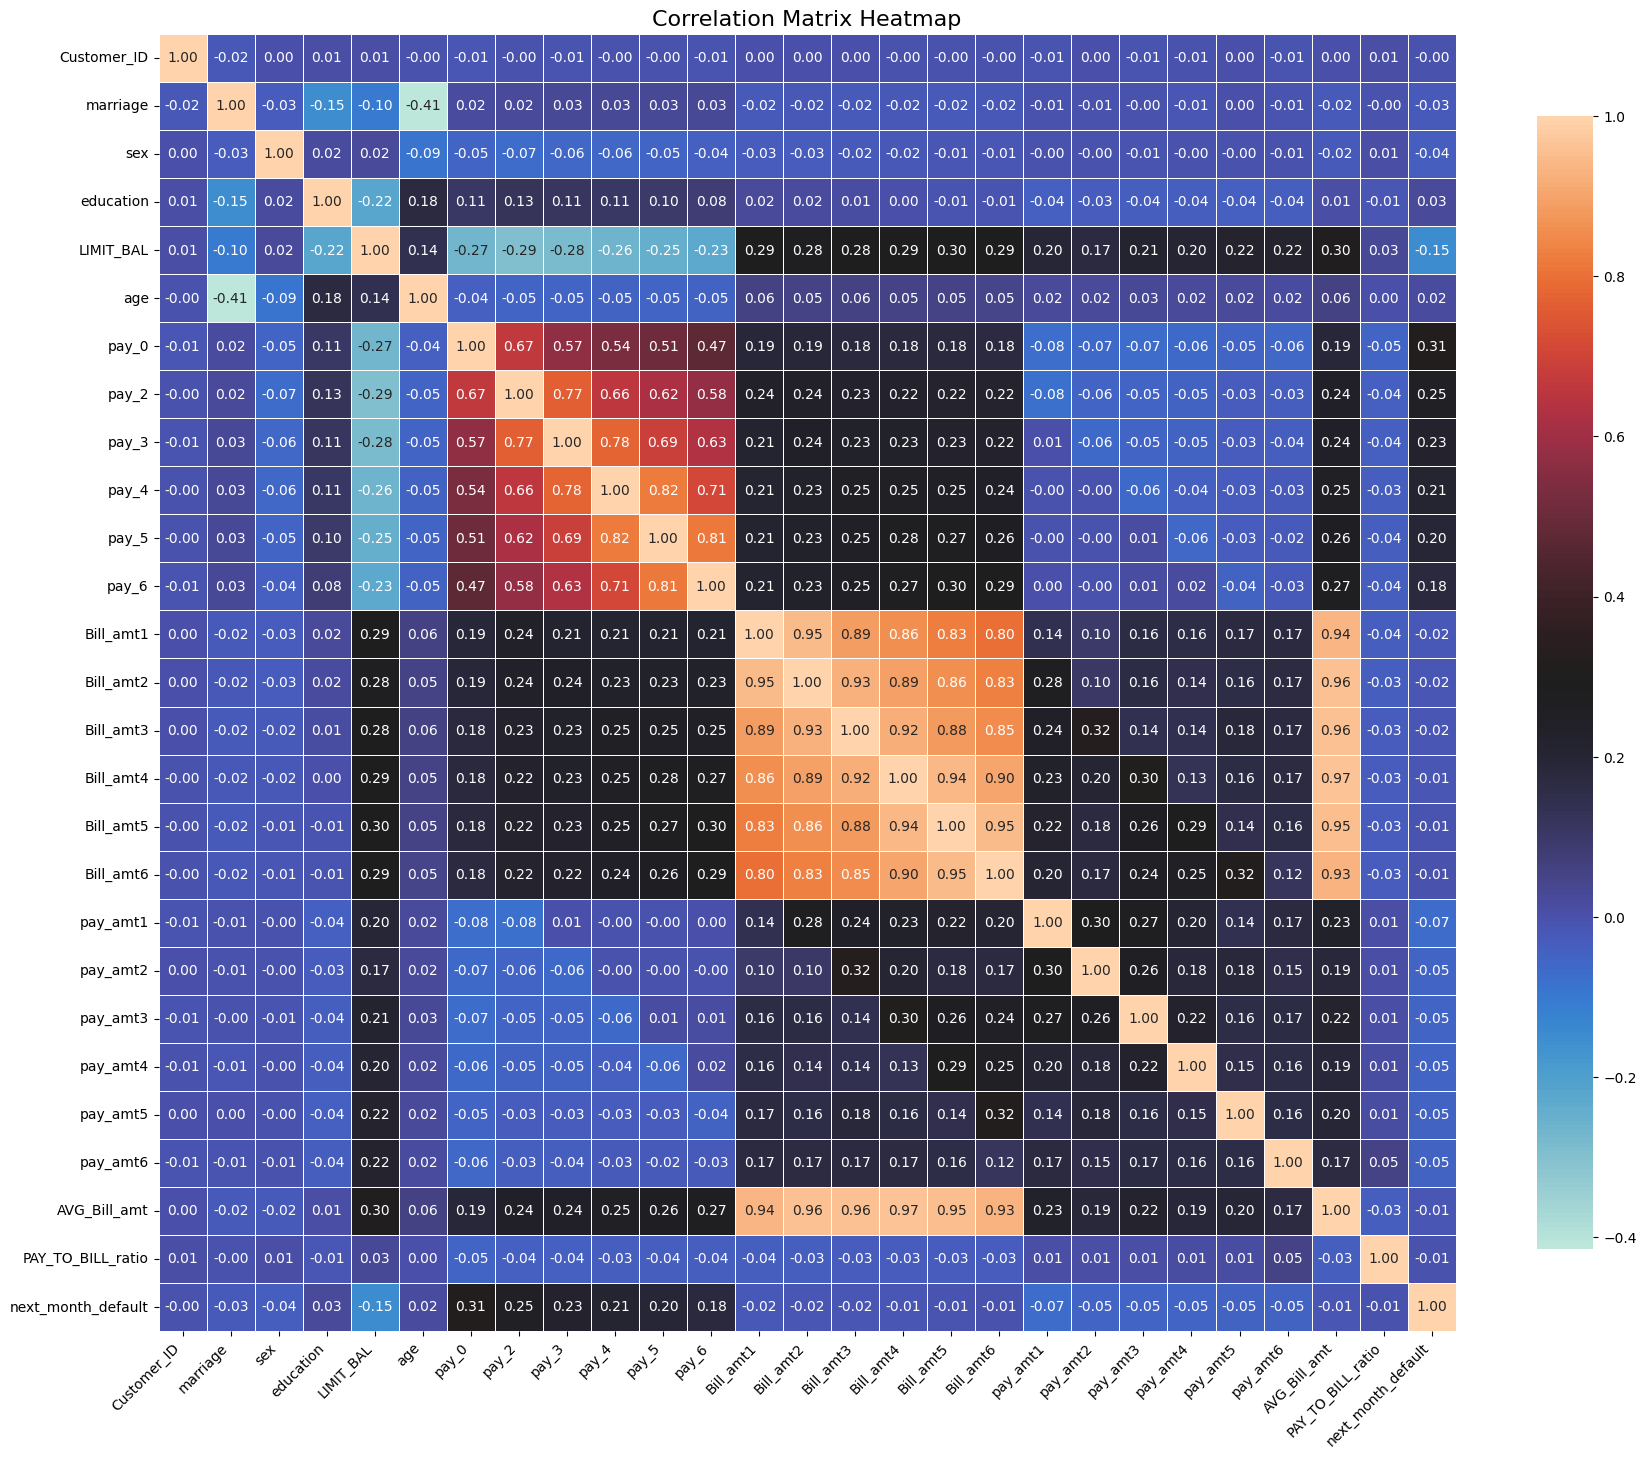

In [136]:
corr_matrix = train_df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(18, 16))
sns.heatmap(
    corr_matrix,
    cmap='icefire',
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75}
)
plt.title("Correlation Matrix Heatmap", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Data preprocessing and encoding

In [137]:
train_df.drop(columns='Customer_ID', inplace=True)

In [138]:
print(train_df.sex.value_counts())
print('-' * 50)
print(train_df.education.value_counts())
print('-' * 50)
print(train_df.marriage.value_counts())
print('-' * 50)

sex
1    15252
0     9995
Name: count, dtype: int64
--------------------------------------------------
education
2    11717
1     8988
3     4115
5      253
4      116
6       44
0       14
Name: count, dtype: int64
--------------------------------------------------
marriage
2    13441
1    11480
3      273
0       53
Name: count, dtype: int64
--------------------------------------------------


In [139]:
def normalize_and_encode_categories(df):
    df['sex'] = df['sex'].apply(lambda x: x if x in [0, 1] else -1)
    df['education'] = df['education'].apply(lambda x: x if x in [1, 2, 3] else 4)
    df['marriage'] = df['marriage'].apply(lambda x: x if x in [1, 2] else 3)

    # Convert selected columns to categorical dtype
    categorical_cols = ['sex', 'education', 'marriage']
    for col in categorical_cols:
        df[col] = df[col].astype('category')

    return df

In [140]:
def missing_values(df):
  imputer = SimpleImputer(strategy='median')
  df['age'] = imputer.fit_transform(df[['age']])

  return df

In [141]:
def preprocessing(df):
  df = normalize_and_encode_categories(df)
  df = missing_values(df)

  return df

# Financial feature engineering

In [142]:
from sklearn.linear_model import LinearRegression

def financial_feature_engg(df):

    pay_cols = [f"pay_{i}" for i in [0, 2, 3, 4, 5, 6]]
    bill_cols = [f"Bill_amt{i}" for i in range(1, 7)]
    pay_amt_cols = [f"pay_amt{i}" for i in range(1, 7)]

    # Average Bill and Credit Utilization
    df["avg_bill"] = df[bill_cols].mean(axis=1)
    df["credit_utilization"] = df["avg_bill"] / (df["LIMIT_BAL"] + 1e-6)

    # Total Overdue Months
    df["total_late_payments"] = df[pay_cols].apply(lambda row: (row >= 1).sum(), axis=1)

    # Longest Consecutive Overdue Streak
    def max_delinquency_streak(row):
        streak = max_streak = 0
        for val in row:
            if val >= 1:
                streak += 1
                max_streak = max(max_streak, streak)
            else:
                streak = 0
        return max_streak
    df["longest_delinquency_streak"] = df[pay_cols].apply(max_delinquency_streak, axis=1)

    # Recent Overdue Count (['pay_0', 'pay_2', 'pay_3'])
    df["recent_overdue_count"] = df[pay_cols[:3]].apply(lambda row: (row >= 1).sum(), axis=1)

    # Has Recent Delinquency Flag
    df["has_recent_delinquency"] = df[["pay_0", "pay_2"]].apply(lambda row: int(any(row >= 1)), axis=1)

    # Monthly Repayment Ratios
    ratios = np.where(df[bill_cols] > 0, df[pay_amt_cols].values / df[bill_cols].values, 0)
    df['pay_ratio_std'] = np.std(ratios, axis=1)
    df['pay_ratio_min'] = np.min(ratios, axis=1)
    df['pay_ratio_max'] = np.max(ratios, axis=1)

    # Flags
    df["high_utilization_flag"] = (df["credit_utilization"] > 0.9).astype(int)
    df["overpaid_flag"] = df[bill_cols].apply(lambda row: any(row < 0), axis=1).astype(int)

    # Slope of Bill & Payment Trends
    months = np.array(range(1, 7)).reshape(-1, 1)

    def compute_slope(row, cols):
        model = LinearRegression()
        y = row[cols].values.reshape(-1, 1)
        model.fit(months, y)
        return model.coef_[0][0]

    df["bill_slope"] = df[bill_cols].apply(lambda row: compute_slope(row, bill_cols), axis=1)
    df["pay_slope"] = df[pay_amt_cols].apply(lambda row: compute_slope(row, pay_amt_cols), axis=1)

    return df

In [143]:
train_df = preprocessing(train_df)
train_df = financial_feature_engg(train_df)

In [144]:
# dropping highly related columns
drop_cols = [
    'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5',
    'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6'
]

train_df.drop(columns=drop_cols, inplace=True)

# SMOTE

In [145]:
train_df.next_month_default.value_counts()

,count
next_month_default,
0,20440
1,4807


In [146]:
def onehot_encode(df):
  df = pd.get_dummies(train_df, columns=["sex", "marriage", "education"], drop_first=True)
  return df

train_df = onehot_encode(train_df)

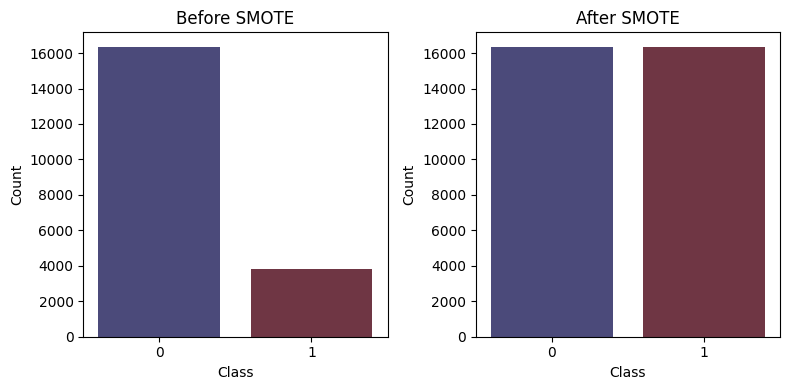

 Class Distribution:

       Before SMOTE  After SMOTE
Class                           
0             16352        16352
1              3845        16352


In [147]:
from sklearn.preprocessing import StandardScaler
X = train_df.drop(columns=["next_month_default"])
y = train_df["next_month_default"]

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.countplot(x=y_train, ax=axes[0], palette='icefire').set(title='Before SMOTE', xlabel='Class', ylabel='Count',)
sns.countplot(x=y_train_smote, ax=axes[1], palette='icefire').set(title='After SMOTE', xlabel='Class', ylabel='Count')

plt.tight_layout()
plt.show()

before_counts = pd.Series(Counter(y_train)).rename("Before SMOTE")
after_counts = pd.Series(Counter(y_train_smote)).rename("After SMOTE")

smote_comparison = pd.concat([before_counts, after_counts], axis=1)
smote_comparison.index.name = "Class"
print(" Class Distribution:\n")
print(smote_comparison)

# Model Training

## 1) Logistic Regression

Logistic Regression
F2 Score: 0.5596508244422891
              precision    recall  f1-score   support

           0       0.90      0.82      0.86      4088
           1       0.44      0.60      0.51       962

    accuracy                           0.78      5050
   macro avg       0.67      0.71      0.68      5050
weighted avg       0.81      0.78      0.79      5050



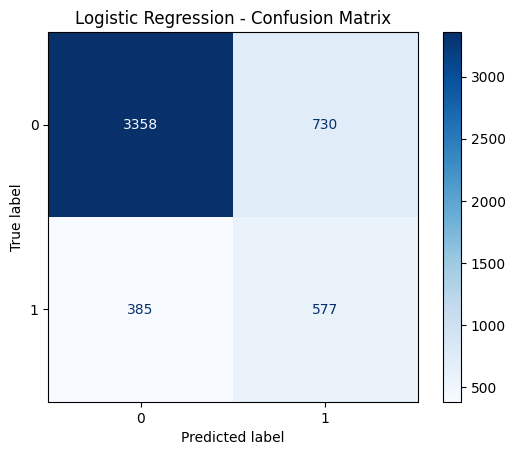

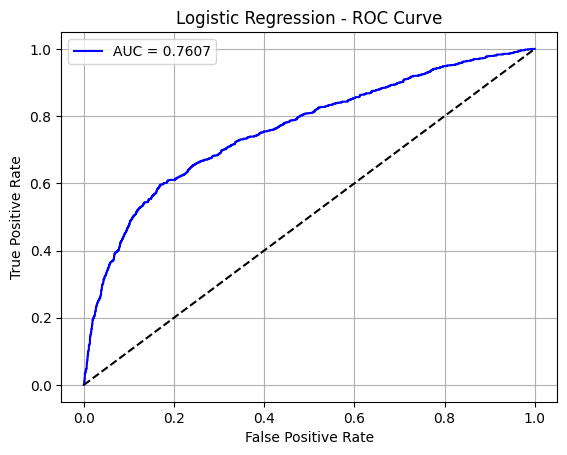

In [148]:
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_train_smote, y_train_smote)

y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]

print("Logistic Regression")
print("F2 Score:", fbeta_score(y_test, y_pred, beta=2))
print(classification_report(y_test, y_pred))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.4f}", color='blue')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Logistic Regression - ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.legend()
plt.show()

## 2) Decision Tree

Decision Tree Performance on Test Set:
Accuracy: 0.7928712871287129
F1 Score: 0.4872549019607843
F2 Score: 0.5044660982541616
ROC AUC: 0.760766387906799

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      4088
           1       0.46      0.52      0.49       962

    accuracy                           0.79      5050
   macro avg       0.67      0.69      0.68      5050
weighted avg       0.80      0.79      0.80      5050



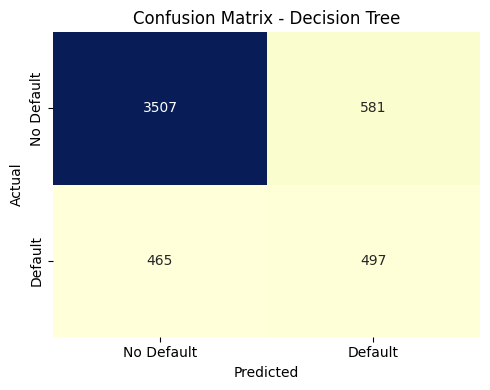

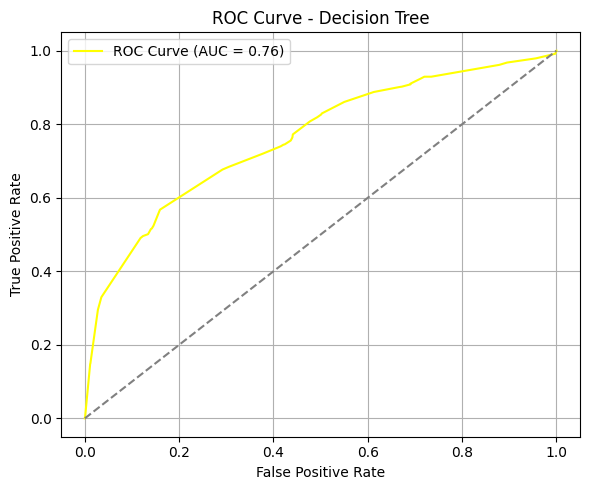

In [149]:
dt = DecisionTreeClassifier(max_depth=6, random_state=42)
dt.fit(X_train_smote, y_train_smote)

y_pred = dt.predict(X_test)
y_prob = dt.predict_proba(X_test)[:, 1]

# Evaluation Metrics
print("Decision Tree Performance on Test Set:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("F2 Score:", fbeta_score(y_test, y_pred, beta=2))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=False,
            xticklabels=["No Default", "Default"],
            yticklabels=["No Default", "Default"])
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_prob):.2f})", color='yellow')
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve - Decision Tree")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 3) Random Forest

Random Forest
F2 Score: 0.45601204560120456
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      4088
           1       0.53      0.44      0.48       962

    accuracy                           0.82      5050
   macro avg       0.70      0.67      0.69      5050
weighted avg       0.81      0.82      0.81      5050



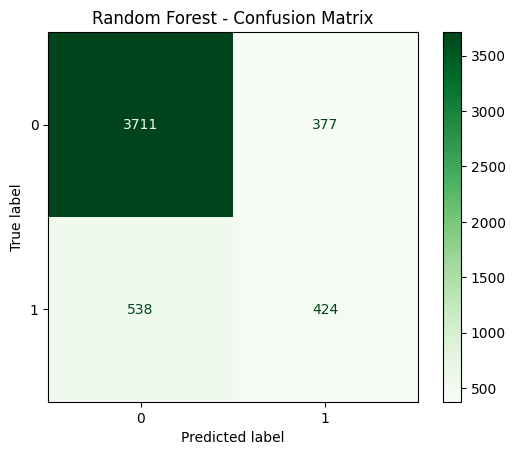

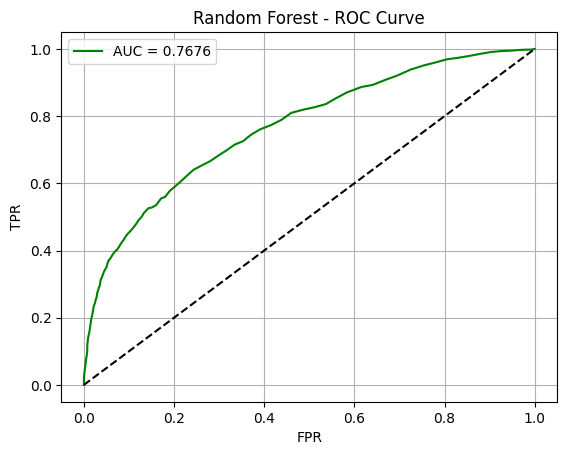

In [150]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_smote, y_train_smote)

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

print("Random Forest")
print("F2 Score:", fbeta_score(y_test, y_pred, beta=2))
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Greens')
plt.title("Random Forest - Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.4f}", color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Random Forest - ROC Curve")
plt.grid()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

## 4) XGBoost

XGBoost
F2 Score: 0.4172229639519359
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      4088
           1       0.58      0.39      0.47       962

    accuracy                           0.83      5050
   macro avg       0.72      0.66      0.68      5050
weighted avg       0.81      0.83      0.82      5050



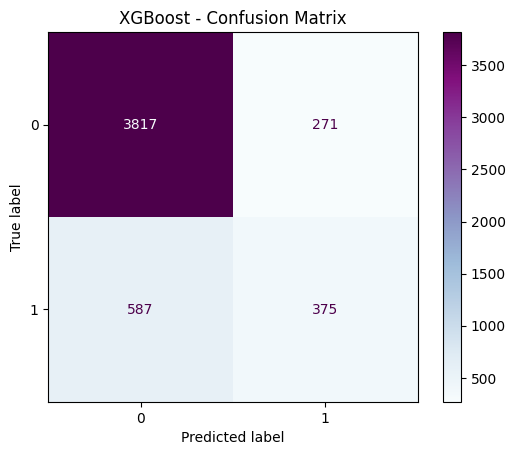

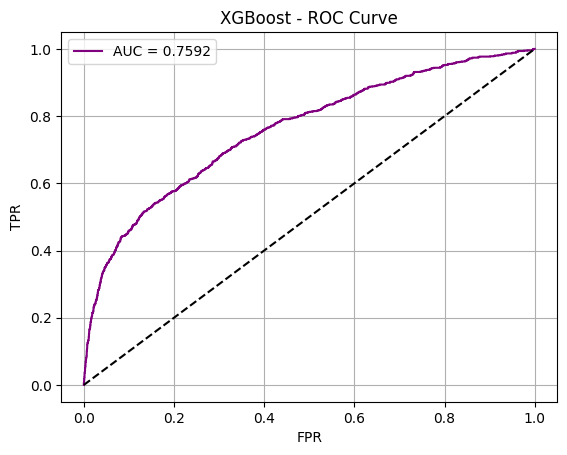

In [151]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_smote, y_train_smote)

y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

print("XGBoost")
print("F2 Score:", fbeta_score(y_test, y_pred, beta=2))
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='BuPu')
plt.title("XGBoost - Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.4f}", color='purple')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("XGBoost - ROC Curve")
plt.grid()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

## 5) LightGBM

[LightGBM] [Info] Number of positive: 16352, number of negative: 16352
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6377
[LightGBM] [Info] Number of data points in the train set: 32704, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

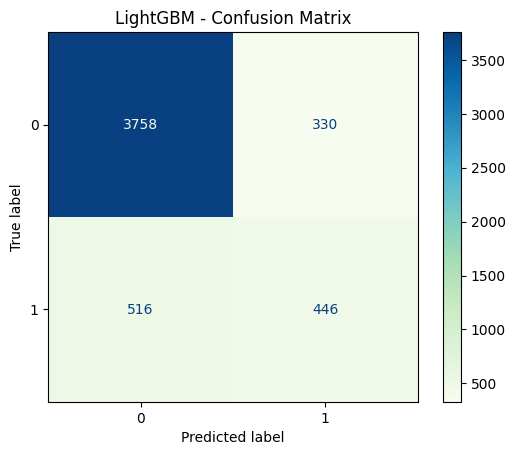

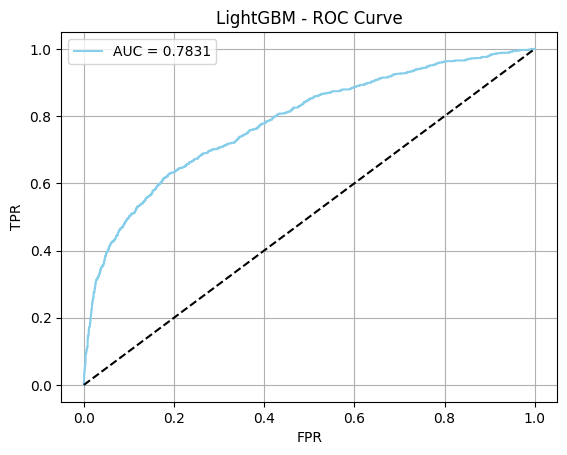

In [152]:
lgbm = LGBMClassifier(n_estimators=100, max_depth=5, random_state=42)
lgbm.fit(X_train_smote, y_train_smote)

y_pred = lgbm.predict(X_test)
y_prob = lgbm.predict_proba(X_test)[:, 1]
f2 = fbeta_score(y_test, y_pred, beta=2)

print("LightGBM")
print("F2 Score:", fbeta_score(y_test, y_pred, beta=2))
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='GnBu')
plt.title("LightGBM - Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.4f}", color='skyblue')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("LightGBM - ROC Curve")
plt.grid()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

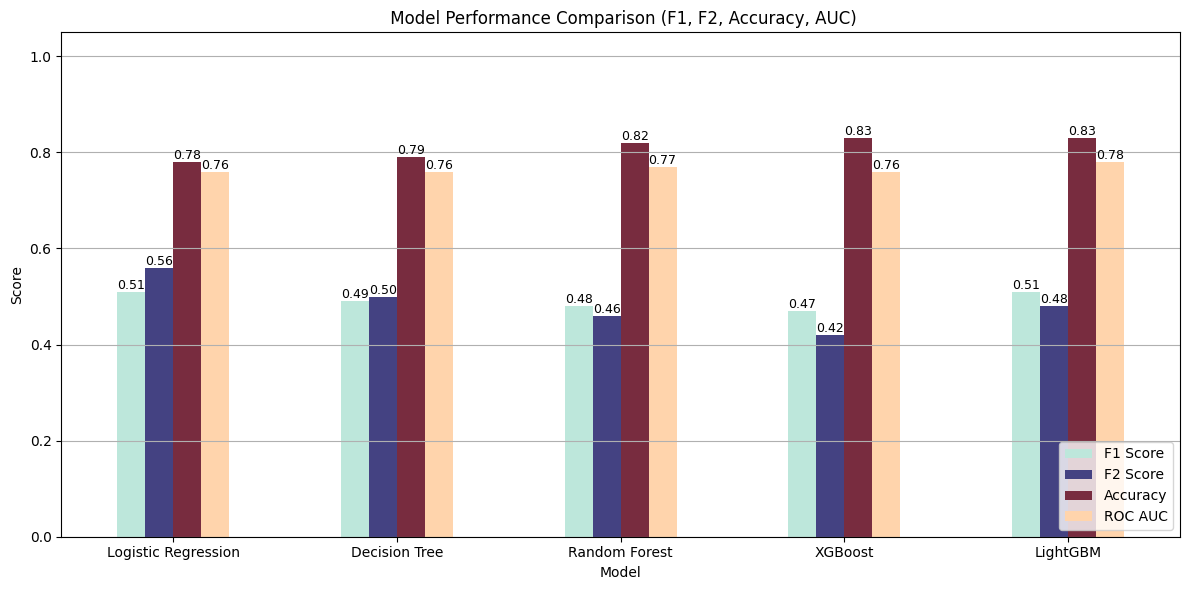

In [153]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    return {
        "Model": name,
        "F1 Score": f1_score(y_test, y_pred),
        "F2 Score": fbeta_score(y_test, y_pred, beta=2),
        "Accuracy": accuracy_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_prob)
    }

models = [
    ("Logistic Regression", log_reg),
    ("Decision Tree", dt),
    ("Random Forest", rf),
    ("XGBoost", xgb_model),
    ("LightGBM", lgbm),
]

results = [evaluate_model(name, model, X_test, y_test) for name, model in models]
results_df = pd.DataFrame(results).set_index("Model")
results_rounded = results_df.round(2)

# Plot
ax = results_rounded.plot(kind='bar', figsize=(12, 6), colormap='icefire')
plt.title(" Model Performance Comparison (F1, F2, Accuracy, AUC)")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.legend(loc='lower right')

# Annotate each bar with its value
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.2f}",
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 6) Ensemble Model

Stacked Ensemble Performance:
Accuracy: 0.8201980198019801
F1 Score: 0.5133976420150054
F2 Score: 0.5039983164983165
ROC AUC: 0.7776551012852383

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89      4088
           1       0.53      0.50      0.51       962

    accuracy                           0.82      5050
   macro avg       0.71      0.70      0.70      5050
weighted avg       0.82      0.82      0.82      5050



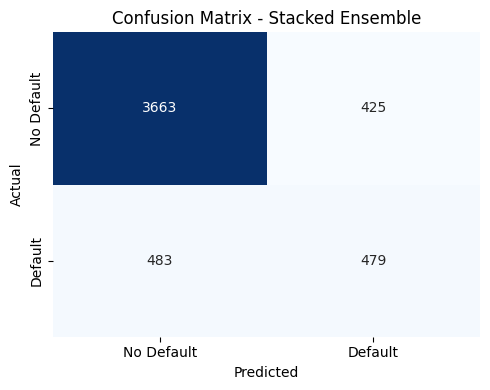

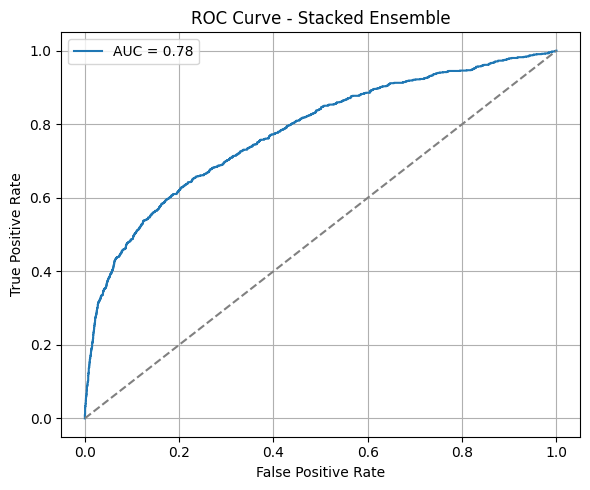

In [154]:
stacked_clf = StackingClassifier(
    estimators=[
        ('log_reg', log_reg),
        ('dt', dt),
        # ('rf', rf),
        # ('xgb', xgb_model),
        ('lgbm', lgbm)
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    passthrough=False,
    n_jobs=-1
)

stacked_clf.fit(X_train_smote, y_train_smote)

y_pred_stack = stacked_clf.predict(X_test)
y_prob_stack = stacked_clf.predict_proba(X_test)[:, 1]

# Scores
print("Stacked Ensemble Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_stack))
print("F1 Score:", f1_score(y_test, y_pred_stack))
print("F2 Score:", fbeta_score(y_test, y_pred_stack, beta=2))
print("ROC AUC:", roc_auc_score(y_test, y_prob_stack))
print("\nClassification Report:\n", classification_report(y_test, y_pred_stack))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_stack)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Default", "Default"],
            yticklabels=["No Default", "Default"])
plt.title("Confusion Matrix - Stacked Ensemble")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_stack)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob_stack):.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve - Stacked Ensemble")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [155]:
y_scores_stack = stacked_clf.predict_proba(X_test)[:, 1]
thresholds = np.arange(0.1, 0.91, 0.01)

scores = []
for t in thresholds:
    preds = (y_scores_stack >= t).astype(int)
    scores.append([
        t,
        f1_score(y_test, preds),
        fbeta_score(y_test, preds, beta=2),
        accuracy_score(y_test, preds)
    ])

score_df = pd.DataFrame(scores, columns=["Threshold", "F1", "F2", "Accuracy"])
best = score_df.loc[score_df["F2"].idxmax()]

print("Best Threshold for Stacked Ensemble:")
print(best)

Best Threshold for Stacked Ensemble:
Threshold    0.160000
F1           0.427020
F2           0.605014
Accuracy     0.571683
Name: 6, dtype: float64



Tuned Ensemble at Threshold = 0.16
F1: 0.42701986754966886
F2: 0.6050142621228044
Accuracy: 0.5716831683168316
AUC: 0.7776551012852383

               precision    recall  f1-score   support

           0       0.93      0.51      0.66      4088
           1       0.29      0.84      0.43       962

    accuracy                           0.57      5050
   macro avg       0.61      0.67      0.54      5050
weighted avg       0.81      0.57      0.61      5050



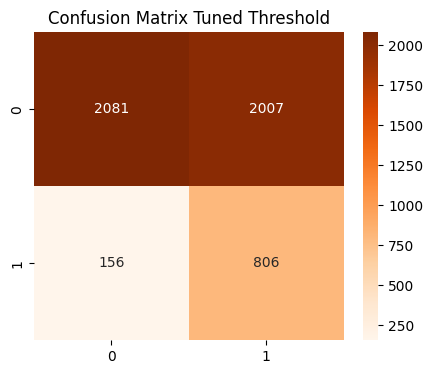

In [156]:
best_thresh = best["Threshold"]
y_pred_opt = (y_scores_stack >= best_thresh).astype(int)

print("\nTuned Ensemble at Threshold =", round(best_thresh, 2))
print("F1:", f1_score(y_test, y_pred_opt))
print("F2:", fbeta_score(y_test, y_pred_opt, beta=2))
print("Accuracy:", accuracy_score(y_test, y_pred_opt))
print("AUC:", roc_auc_score(y_test, y_scores_stack))
print("\n", classification_report(y_test, y_pred_opt))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_opt)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges")
plt.title("Confusion Matrix Tuned Threshold")
plt.show()

In [157]:
from sklearn.ensemble import VotingClassifier

clf1 = LogisticRegression()
clf2 = RandomForestClassifier()
clf3 = XGBClassifier()
clf4 = LGBMClassifier()

voting_clf_soft = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2),('xgb', clf3), ('lgbm', clf4)],
    voting='soft'
)

voting_clf_soft.fit(X_train_smote, y_train_smote)
y_prob_vote = voting_clf_soft.predict_proba(X_test)[:, 1]

# Threshold tuning
thresholds = np.arange(0.1, 0.91, 0.01)
results = []

for t in thresholds:
    preds = (y_prob_vote >= t).astype(int)
    f1 = f1_score(y_test, preds)
    f2 = fbeta_score(y_test, preds, beta=2)
    acc = accuracy_score(y_test, preds)
    results.append((t, f1, f2, acc, (f1 + f2 + acc) / 3))

threshold_df = pd.DataFrame(results, columns=["Threshold", "F1", "F2", "Accuracy", "BalancedScore"])

# Get best thresholds
t_default = 0.5
t_best_f1 = threshold_df.iloc[threshold_df["F1"].idxmax()]["Threshold"]
t_best_f2 = threshold_df.iloc[threshold_df["F2"].idxmax()]["Threshold"]
t_best_acc = threshold_df.iloc[threshold_df["Accuracy"].idxmax()]["Threshold"]
t_best_avg = threshold_df.iloc[threshold_df["BalancedScore"].idxmax()]["Threshold"]

thresholds_to_plot = [
    ("Default (0.5)", t_default),
    ("Best F1", t_best_f1),
    ("Best F2", t_best_f2),
    ("Best Accuracy", t_best_acc),
    ("Best Balanced Avg", t_best_avg)
]

[LightGBM] [Info] Number of positive: 16352, number of negative: 16352
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6377
[LightGBM] [Info] Number of data points in the train set: 32704, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Final Evaluation with Threshold = 0.24999999999999992
F1 Score: 0.44870283018867924
F2 Score: 0.606084740363173
Accuracy: 0.6297029702970297
ROC AUC: 0.7851446961036002


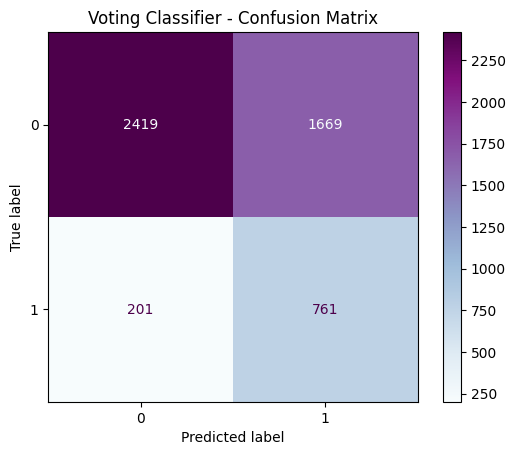

In [158]:
final_threshold = t_best_f2

final_preds = (y_prob_vote >= final_threshold).astype(int)

print("Final Evaluation with Threshold =", final_threshold)
print("F1 Score:", f1_score(y_test, final_preds))
print("F2 Score:", fbeta_score(y_test, final_preds, beta=2))
print("Accuracy:", accuracy_score(y_test, final_preds))
print("ROC AUC:", roc_auc_score(y_test, y_prob_vote))
ConfusionMatrixDisplay.from_predictions(y_test, final_preds, cmap='BuPu')
plt.title("Voting Classifier - Confusion Matrix")
plt.show()

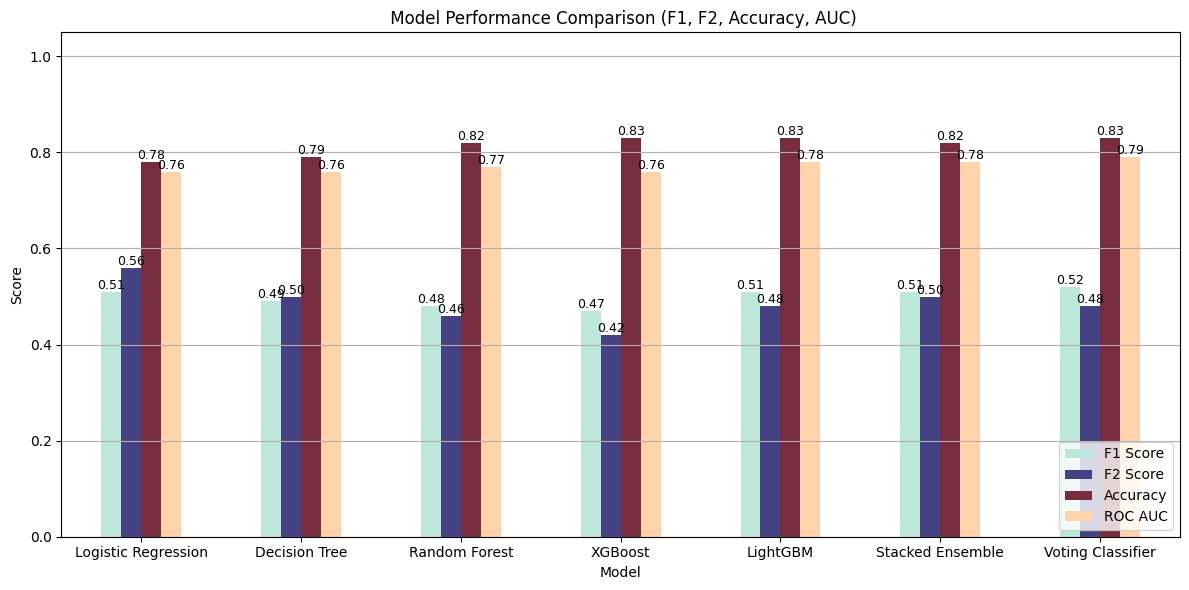

In [159]:
models = [
    ("Logistic Regression", log_reg),
    ("Decision Tree", dt),
    ("Random Forest", rf),
    ("XGBoost", xgb_model),
    ("LightGBM", lgbm),
    ("Stacked Ensemble", stacked_clf),
    ("Voting Classifier", voting_clf_soft)
]

results = [evaluate_model(name, model, X_test, y_test) for name, model in models]
results_df = pd.DataFrame(results).set_index("Model")
results_rounded = results_df.round(2)

# Plot
ax = results_rounded.plot(kind='bar', figsize=(12, 6), colormap='icefire')
plt.title(" Model Performance Comparison (F1, F2, Accuracy, AUC)")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.legend(loc='lower right')

# Annotate each bar with its value
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.2f}",
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Hyperparameter Tuning

In [160]:
def evaluate_thresholds(y_true, y_prob, thresholds=None):
    if thresholds is None:
        thresholds = np.linspace(0.3, 0.9, 7)

    results = []
    auc = roc_auc_score(y_true, y_prob)

    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        results.append({
            "Threshold": round(t, 2),
            "Accuracy": round(accuracy_score(y_true, y_pred), 3),
            "F1 Score": round(f1_score(y_true, y_pred), 3),
            "F2 Score": round(fbeta_score(y_true, y_pred, beta=2), 3),
            "ROC AUC": round(auc, 3)
        })

    return pd.DataFrame(results)

## 1) Logistic Regression

In [161]:
best_log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
best_log_reg.fit(X_train_smote, y_train_smote)

y_prob_log = best_log_reg.predict_proba(X_test)[:, 1]
threshold_metrics = evaluate_thresholds(y_test, y_prob_log)
print(threshold_metrics)

   Threshold  Accuracy  F1 Score  F2 Score  ROC AUC
0        0.3     0.404     0.368     0.572    0.761
1        0.4     0.654     0.448     0.586    0.761
2        0.5     0.779     0.509     0.560    0.761
3        0.6     0.800     0.509     0.530    0.761
4        0.7     0.822     0.490     0.465    0.761
5        0.8     0.832     0.397     0.325    0.761
6        0.9     0.820     0.167     0.114    0.761



Tuned Logistic Regression Performance @ Threshold = 0.37
Accuracy: 0.579
F1 Score: 0.417
F2 Score: 0.582
ROC AUC: 0.761

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.53      0.67      4088
           1       0.28      0.79      0.42       962

    accuracy                           0.58      5050
   macro avg       0.60      0.66      0.54      5050
weighted avg       0.79      0.58      0.62      5050



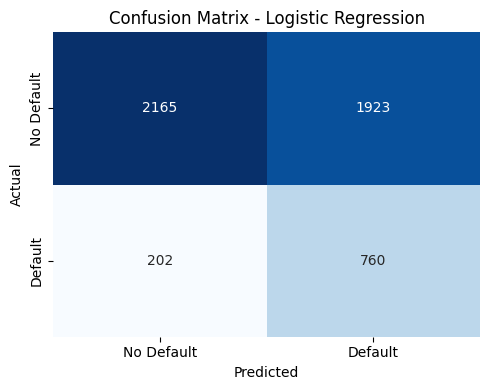

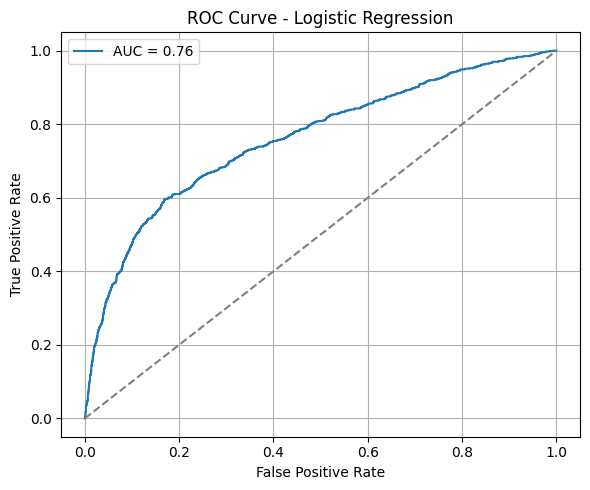

In [162]:
threshold = 0.37
tuned_models = {
    "Tuned LogisticRegression": {"model": LogisticRegression(), "threshold": threshold}
}
y_pred_log = (y_prob_log >= threshold).astype(int)

print(f"\nTuned Logistic Regression Performance @ Threshold = {threshold}")
print("Accuracy:", round(accuracy_score(y_test, y_pred_log), 3))
print("F1 Score:", round(f1_score(y_test, y_pred_log), 3))
print("F2 Score:", round(fbeta_score(y_test, y_pred_log, beta=2), 3))
print("ROC AUC:", round(roc_auc_score(y_test, y_prob_log), 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Default", "Default"],
            yticklabels=["No Default", "Default"])
plt.title(f"Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_log)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob_log):.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve - Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 2) Decision Tree

In [163]:
# best_dt = DecisionTreeClassifier(class_weight='balanced', max_depth=None, random_state=42)
# best_dt.fit(X_train_smote, y_train_smote)

# y_prob_dt = best_dt.predict_proba(X_test)[:, 1]
# threshold_metrics = evaluate_thresholds(y_test, y_prob_dt)
# print(threshold_metrics)

   Threshold  Accuracy  F1 Score  F2 Score  ROC AUC
0        0.3     0.725     0.378     0.412    0.615
1        0.4     0.725     0.378     0.412    0.615
2        0.5     0.725     0.378     0.412    0.615
3        0.6     0.725     0.378     0.412    0.615
4        0.7     0.725     0.378     0.412    0.615
5        0.8     0.725     0.378     0.412    0.615
6        0.9     0.725     0.378     0.412    0.615


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 0.7279207920792079
F1 Score: 0.37374658158614404
F2 Score: 0.4035433070866142
ROC AUC: 0.6125595526280457

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.80      0.83      4088
           1       0.33      0.43      0.37       962

    accuracy                           0.73      5050
   macro avg       0.59      0.61      0.60      5050
weighted avg       0.76      0.73      0.74      5050



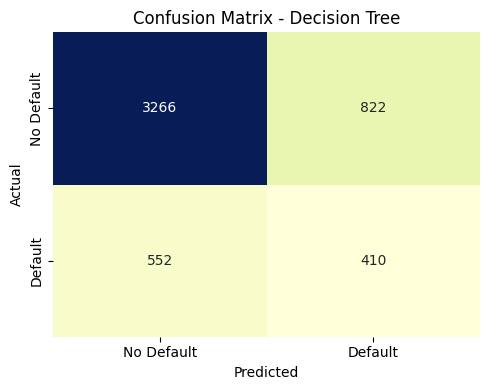

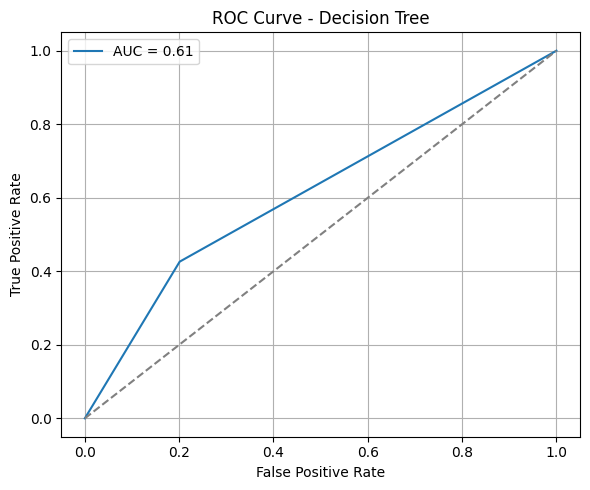

In [164]:
f2_scorer = make_scorer(fbeta_score, beta=2)

param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

grid_search_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(class_weight='balanced', random_state=42),
    param_grid=param_grid,
    scoring=f2_scorer,
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search_dt.fit(X_train_smote, y_train_smote)
best_dt = grid_search_dt.best_estimator_
y_pred = best_dt.predict(X_test)
y_prob = best_dt.predict_proba(X_test)[:, 1]

print("Best Parameters:", grid_search_dt.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("F2 Score:", fbeta_score(y_test, y_pred, beta=2))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=False,
            xticklabels=["No Default", "Default"],
            yticklabels=["No Default", "Default"])
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve - Decision Tree")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 3) Random Forest

In [165]:
best_rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, max_depth=10,n_jobs=-1)
best_rf.fit(X_train_smote, y_train_smote)

y_prob_rf = best_rf.predict_proba(X_test)[:, 1]
threshold_metrics = evaluate_thresholds(y_test, y_prob_rf)
print(threshold_metrics)

   Threshold  Accuracy  F1 Score  F2 Score  ROC AUC
0        0.3     0.568     0.425     0.603    0.785
1        0.4     0.724     0.488     0.593    0.785
2        0.5     0.805     0.518     0.536    0.785
3        0.6     0.831     0.502     0.467    0.785
4        0.7     0.839     0.462     0.397    0.785
5        0.8     0.840     0.384     0.299    0.785
6        0.9     0.823     0.162     0.109    0.785



Tuned Random Forest Performance
Accuracy: 0.694059405940594
F1 Score: 0.4728761514841351
F2 Score: 0.5956678700361011
ROC AUC: 0.7845514583528281

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.69      0.78      4088
           1       0.35      0.72      0.47       962

    accuracy                           0.69      5050
   macro avg       0.63      0.70      0.63      5050
weighted avg       0.81      0.69      0.73      5050



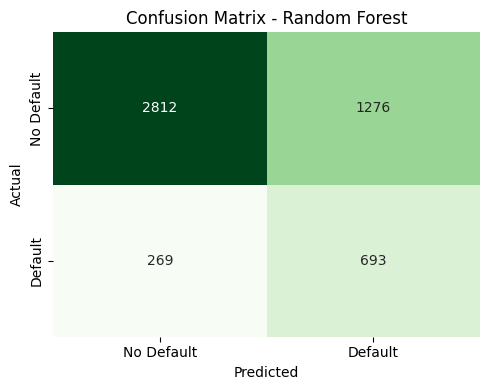

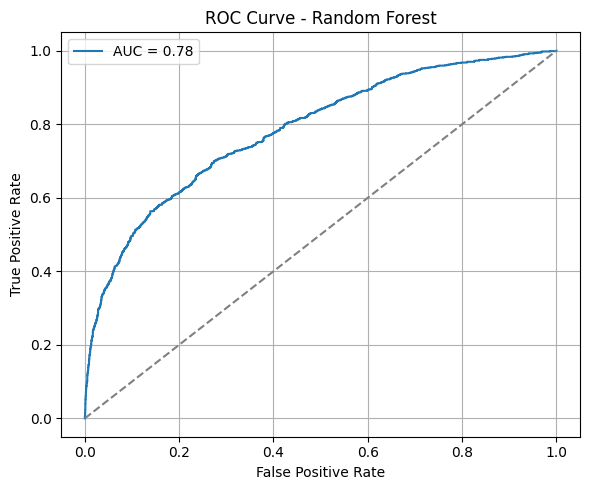

In [166]:
threshold = 0.38
y_pred_rf = (y_prob_rf >= threshold).astype(int)

print(f"\nTuned Random Forest Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("F2 Score:", fbeta_score(y_test, y_pred_rf, beta=2))
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", cbar=False,
            xticklabels=["No Default", "Default"],
            yticklabels=["No Default", "Default"])
plt.title(f"Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob_rf):.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve - Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 4) XGBoost

In [167]:
best_xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=1,
    random_state=42
)
best_xgb.fit(X_train_smote, y_train_smote)

y_prob_xgb = best_xgb.predict_proba(X_test)[:, 1]
threshold_metrics = evaluate_thresholds(y_test, y_prob_xgb)
print(threshold_metrics)

   Threshold  Accuracy  F1 Score  F2 Score  ROC AUC
0        0.3     0.770     0.482     0.527    0.759
1        0.4     0.814     0.486     0.472    0.759
2        0.5     0.830     0.466     0.417    0.759
3        0.6     0.839     0.434     0.361    0.759
4        0.7     0.835     0.358     0.277    0.759
5        0.8     0.827     0.235     0.166    0.759
6        0.9     0.816     0.090     0.059    0.759



Tuned XGBoost Performance = 0.3
Accuracy: 0.7700990099009901
F1 Score: 0.4823896567097637
F2 Score: 0.527393254045623
ROC AUC: 0.7591726812617223

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.82      0.85      4088
           1       0.42      0.56      0.48       962

    accuracy                           0.77      5050
   macro avg       0.66      0.69      0.67      5050
weighted avg       0.80      0.77      0.78      5050



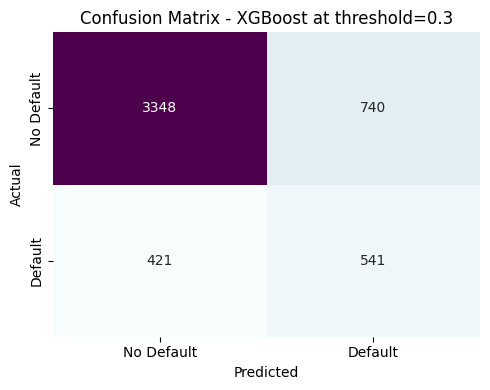

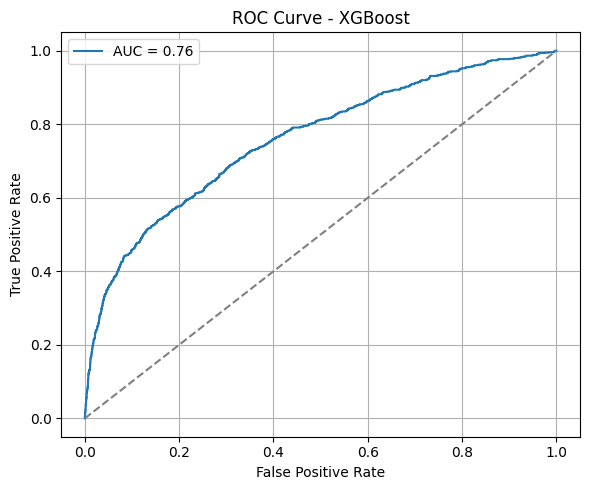

In [168]:
threshold = 0.30
y_pred_xgb = (y_prob_xgb >= threshold).astype(int)

# Evaluation
print(f"\nTuned XGBoost Performance = {threshold}")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb))
print("F2 Score:", fbeta_score(y_test, y_pred_xgb, beta=2))
print("ROC AUC:", roc_auc_score(y_test, y_prob_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="BuPu", cbar=False,
            xticklabels=["No Default", "Default"],
            yticklabels=["No Default", "Default"])
plt.title(f"Confusion Matrix - XGBoost at threshold={threshold}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_xgb)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob_xgb):.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve - XGBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 5) LightGBM

In [169]:
best_lgbm = LGBMClassifier(class_weight='balanced', random_state=42, n_estimators=100)
best_lgbm.fit(X_train_smote, y_train_smote)

y_prob_lgbm = best_lgbm.predict_proba(X_test)[:, 1]
threshold_metrics = evaluate_thresholds(y_test, y_prob_lgbm)
print(threshold_metrics)

[LightGBM] [Info] Number of positive: 16352, number of negative: 16352
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6377
[LightGBM] [Info] Number of data points in the train set: 32704, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
   Threshold  Accuracy  F1 Score  F2 Score  ROC AUC
0        0.3     0.775     0.510     0.567    0.776
1        0.4     0.821     0.517     0.509    0.776
2        0.5     0.841     0.499     0.446    0.776
3        0.6     0.847     0.466     0.390    0.776
4        0.7     0.841     0.384     0.299    0.776
5        0.8     0.827     0.220     0.154    0.776
6        0.9     0.812     0.029     0.018    0.776



Tuned LightGBM Performance
Accuracy: 0.7752475247524753
F1 Score: 0.509719222462203
F2 Score: 0.5671986156508364
ROC AUC: 0.7762072248373618

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.81      0.85      4088
           1       0.44      0.61      0.51       962

    accuracy                           0.78      5050
   macro avg       0.67      0.71      0.68      5050
weighted avg       0.81      0.78      0.79      5050



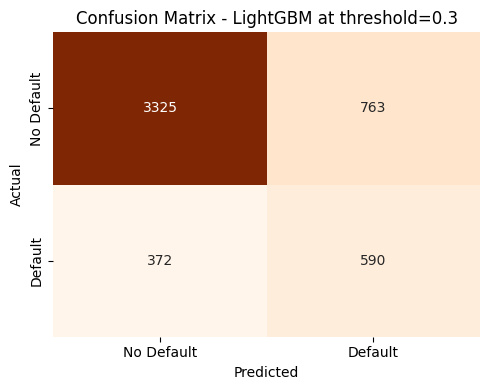

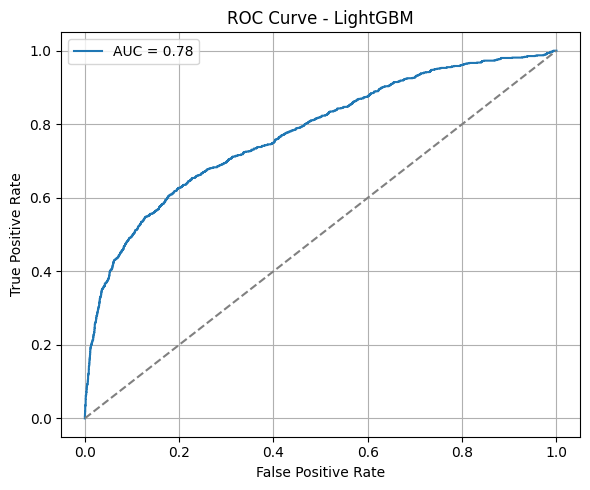

In [170]:
threshold = 0.30
y_pred_lgbm = (y_prob_lgbm >= threshold).astype(int)

# Evaluation
print(f"\nTuned LightGBM Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print("F1 Score:", f1_score(y_test, y_pred_lgbm))
print("F2 Score:", fbeta_score(y_test, y_pred_lgbm, beta=2))
print("ROC AUC:", roc_auc_score(y_test, y_prob_lgbm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgbm))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lgbm)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", cbar=False,
            xticklabels=["No Default", "Default"],
            yticklabels=["No Default", "Default"])
plt.title(f"Confusion Matrix - LightGBM at threshold={threshold}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_lgbm)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob_lgbm):.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve - LightGBM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [171]:
def evaluate_model(name, model, X_test, y_test, threshold):
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)
    return {
        'Model': name,
        'F1 Score': round(f1_score(y_test, y_pred), 3),
        'F2 Score': round(fbeta_score(y_test, y_pred, beta=2), 3),
        'Accuracy': round(accuracy_score(y_test, y_pred), 3),
        'ROC AUC': round(roc_auc_score(y_test, y_prob), 3)
    }

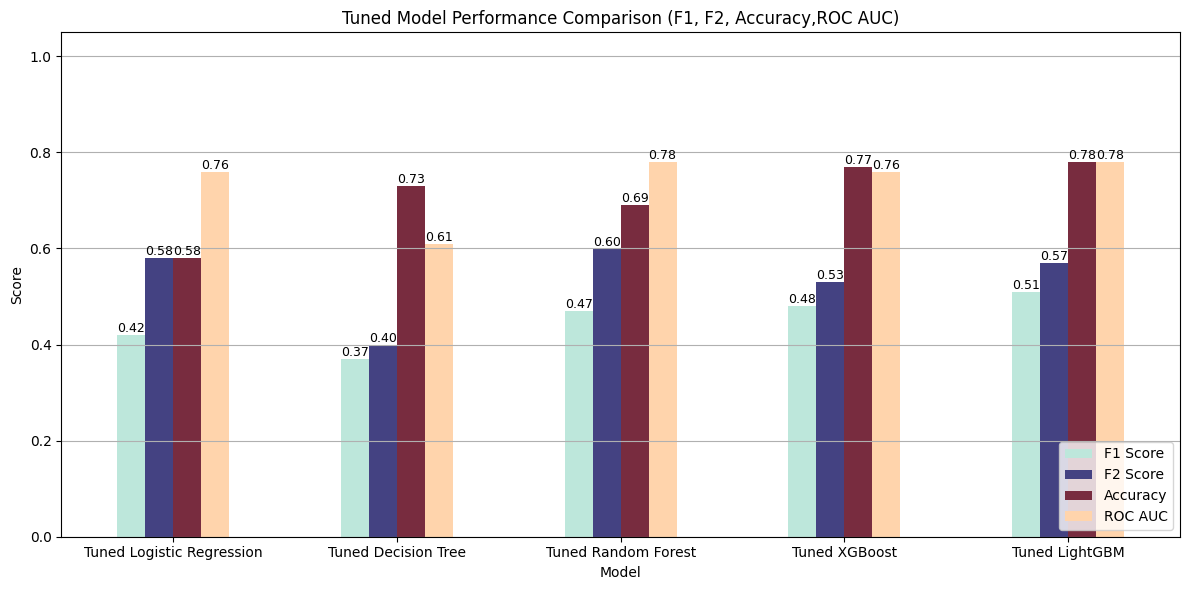

In [172]:
tuned_models = [
    ("Tuned Logistic Regression", best_log_reg, 0.37),
    ("Tuned Decision Tree", best_dt, 0.50),
    ("Tuned Random Forest", best_rf, 0.38),
    ("Tuned XGBoost", best_xgb, 0.30),
    ("Tuned LightGBM", best_lgbm, 0.30)
]

tuned_results = [evaluate_model(name, model, X_test, y_test, threshold) for (name, model, threshold) in tuned_models]
tuned_results_df = pd.DataFrame(tuned_results).set_index("Model")
tuned_results_rounded = tuned_results_df.round(2)

# Plot
ax = tuned_results_rounded.plot(kind='bar', figsize=(12, 6), colormap='icefire')
plt.title("Tuned Model Performance Comparison (F1, F2, Accuracy,ROC AUC)")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.legend(loc='lower right')

# Annotate each bar with its value
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.2f}",
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Recommendation

In [173]:
def recommend_best_model(model_results_df, priority_metrics=None):
    if priority_metrics is None:
        priority_metrics = ['F2 Score', 'Accuracy', 'ROC AUC']

    scores = model_results_df.copy()
    scores.set_index('Model', inplace=True)

    # (min-max scaling)
    for metric in priority_metrics:
        min_val = scores[metric].min()
        max_val = scores[metric].max()
        if max_val > min_val:
            scores[metric] = (scores[metric] - min_val) / (max_val - min_val)
        else:
            scores[metric] = 0.0

    scores['Score'] = scores[priority_metrics].mean(axis=1)

    best_model = scores['Score'].idxmax()
    return best_model, scores.sort_values(by='Score', ascending=False)

In [174]:
merged_df = pd.concat([results_rounded, tuned_results_rounded], axis=0)

In [175]:
# Recommend best model based on selected metrics
best_model_name, ranked_scores = recommend_best_model(tuned_results_rounded.reset_index())

print(" Recommended Best Model:", best_model_name)
best_f2 = tuned_results_rounded.loc[best_model_name, "F2 Score"]
best_acc = tuned_results_rounded.loc[best_model_name, "Accuracy"]
print(f" Best Model F2 Score: {best_f2}")
print(f" Best Model Accuracy: {best_acc}")

 Recommended Best Model: Tuned LightGBM
 Best Model F2 Score: 0.57
 Best Model Accuracy: 0.78


In [176]:
# Sumarry Table
summary_table = merged_df.copy()
summary_table = summary_table.round(3)
summary_table = summary_table.reset_index()

display(summary_table)

,Model,F1 Score,F2 Score,Accuracy,ROC AUC
0,Logistic Regression,0.51,0.56,0.78,0.76
1,Decision Tree,0.49,0.50,0.79,0.76
2,Random Forest,0.48,0.46,0.82,0.77
3,XGBoost,0.47,0.42,0.83,0.76
4,LightGBM,0.51,0.48,0.83,0.78
5,Stacked Ensemble,0.51,0.50,0.82,0.78
6,Voting Classifier,0.52,0.48,0.83,0.79
7,Tuned Logistic Regression,0.42,0.58,0.58,0.76
8,Tuned Decision Tree,0.37,0.40,0.73,0.61
9,Tuned Random Forest,0.47,0.60,0.69,0.78


# Prediction on Validate Dataset

In [177]:
validate_df = pd.read_csv("validate_dataset.csv")

In [178]:
def onehot_encode_val(df):
    cols_to_encode = ['sex', 'marriage', 'education']
    valid_cols = [col for col in cols_to_encode if col in df.columns]
    return pd.get_dummies(df, columns=valid_cols, drop_first=True)

In [179]:
validate_df = validate_df.drop(columns='Customer_ID')
validate_df = normalize_and_encode_categories(validate_df)
validate_df = missing_values(validate_df)
validate_scaled = financial_feature_engg(validate_df)
validate_scaled = onehot_encode_val(validate_scaled)
# dropping highly related columns
drop_cols = [
    'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5',
    'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6'
]

validate_scaled.drop(columns=drop_cols, inplace=True)
X_validate_scaled = scaler.transform(validate_scaled)

In [180]:
val = pd.read_csv("validate_dataset.csv")

In [181]:
threshold = 0.30
y_val_prob = best_lgbm.predict_proba(X_validate_scaled)[:, 1]
y_val_pred = (y_val_prob >= threshold).astype(int)

val["next_month_default"] = y_val_pred

val[["Customer_ID", "next_month_default"]].to_csv("submission_23112073.csv", index=False)
print("Predictions saved to submission_23112073.csv")

Predictions saved to submission_23112073.csv


In [182]:
val = pd.read_csv("validate_dataset.csv")

In [183]:
predi = pd.read_csv('submission_23112073.csv')

In [184]:
predi.next_month_default.value_counts()

,count
next_month_default,
0,3661
1,1355
